In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import os
import pickle
import glob 
import scipy

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.pipeline import make_pipeline


figpath = os.path.join("fig")
stimulus_path = os.path.join("..","experiment","img_Ntrain1050")


In [3]:
# Expected test MSE computation
def expected_test_loss2(params_true, family_true, model_fitted, ylims, sigma=0.08, x_grid=np.linspace(-1000,1000,1000), epsilon_grid=np.linspace(-3,3,1000), loss_type="MSE"):
    '''Numeric integration to find the expected test MAE/MSE loss'''
    dx = x_grid[1] - x_grid[0]
    depsilon = epsilon_grid[1] - epsilon_grid[0]
    ymin,ymax = ylims
    
    y_true_noiseless = generate_data(x_grid, params_true, family_true)
    y_true_noiseless = (y_true_noiseless - ymin)/(ymax-ymin)
    y_predicted = model_fitted.predict(x_grid.reshape(-1,1))
    delta_pred = y_predicted - y_true_noiseless
    
    epsilon_mat = np.repeat(epsilon_grid[None,:], len(x_grid), axis=0).transpose()
    delta_mat = np.repeat(delta_pred[:,None], len(epsilon_grid), axis=1).transpose()

    gaussian_pdf = scipy.stats.norm.pdf(epsilon_mat, loc=0, scale=sigma)
    gaussian_pdf = gaussian_pdf / np.sum(gaussian_pdf, axis=0)
    
    if(loss_type=="MSE"):
        grid = gaussian_pdf * (delta_mat - epsilon_mat)**2
    else:
        grid = gaussian_pdf * np.abs(delta_mat - epsilon_mat)

    return (np.sum(np.sum(grid)) * dx * depsilon * 1/(max(x_grid)-min(x_grid)))

   
import numpy as np
from scipy.stats import norm

def expected_test_loss(
    params_true,
    family_true,
    model_fitted,
    ylims=None,
    sigma=0.08,                      # std dev of y-noise (sigma_y)
    x_grid=np.linspace(-1000, 1000, 1000),
    loss_type="MSE",                 # "MSE", "MAE", or "DEMING"
    xlims = (-1000,1000),
    deming_lambda=None,              # = sigma_x^2 / sigma_y^2; if None and sigma_x provided, we compute it
    sigma_x=None,                    # optional: std dev of x-noise; if provided, overrides deming_lambda
    grad_eps=None                    # optional: finite-diff step for dy/dx; default picks a small fraction of grid scale
):
    """
    Expected test loss E_{x~Uniform, eps~N(0, sigma^2)}[ loss( y_hat(x), f(x)+eps ) ].
    Closed forms for MSE and MAE; Deming/TLS uses a local linearization with orthogonal residuals.
    For TSE, assume what participants see: a sqaure scatterplot, with equal x and y variances.

    Assumptions:
      - model_fitted.predict returns y_hat on the SAME (normalized) scale as training.
      - If ylims is provided, only y_true is normalized to match predictions.
      - For DEMING, we assume additive Gaussian measurement noise in both x and y.
        Let lambda = Var(eps_x) / Var(eps_y); eps_y std is `sigma`. If `sigma_x` is provided,
        lambda = (sigma_x**2) / (sigma**2). Otherwise use `deming_lambda` (default 1.0).
        The expected squared orthogonal residual is approximated by:
            E[d_perp^2] ≈ (delta^2 + sigma^2) / (1 + (dyhat_dx)^2 / lambda)
        and averaged over x_grid.
    """
    # True function and model predictions
    y_true = generate_data(x_grid, params_true, family_true)
    y_pred = model_fitted.predict(x_grid.reshape(-1, 1)).ravel()

    # Normalize true y if requested
    if ylims is not None:
        ymin, ymax = ylims
        y_true = (y_true - ymin) / (ymax - ymin)

    # Pointwise prediction error on the (normalized) scale
    delta = y_pred - y_true  # shape (N,)

    lt = loss_type.upper()
    if lt == "MSE":
        # E[(delta - eps_y)^2] = delta^2 + sigma^2
        per_x = delta**2 + sigma**2

    elif lt == "MAE":
        # For Z ~ N(mu=delta, sigma^2), E|Z| has a closed form:
        # E|Z| = sigma*sqrt(2/pi)*exp(-delta^2/(2*sigma^2)) + |delta|*(1 - 2*Phi(-|delta|/sigma))
        a = np.abs(delta) / sigma
        per_x = sigma * np.sqrt(2 / np.pi) * np.exp(-0.5 * a**2) + np.abs(delta) * (1 - 2 * norm.cdf(-a))

    elif lt == "TSE":
        # --- Choose coordinate system for TLS ---
        if ylims is None:
            raise ValueError("For DEMING with loss_coords='display', provide xlims and ylims.")

        xmin, xmax = xlims
        ymin, ymax = ylims

        # Map to display coords (square axes)
        x_disp = (x_grid - xmin) / (xmax - xmin)                 # in [0,1] horizontally
        delta_disp = delta
        # Noise in display y-units (sigma given in y units)
        sigma_disp = sigma

        # Finite-diff derivative in *display* x
        if grad_eps is None:
            grad_eps_disp = 1e-5  # step in display x'
        else:
            grad_eps_disp = float(grad_eps)

        # Take finite differences by nudging raw x so that x' moves by grad_eps_disp
        eps_raw = grad_eps_disp * (xmax - xmin)

        x_minus = np.clip(x_grid - eps_raw, x_grid.min(), x_grid.max())
        x_plus  = np.clip(x_grid + eps_raw, x_grid.min(), x_grid.max())

        y_minus_disp = model_fitted.predict(x_minus.reshape(-1,1)).ravel()
        y_plus_disp  = model_fitted.predict(x_plus.reshape(-1,1)).ravel()

        # Central difference in display coords (denominator is 2*grad_eps_disp)
        dy_dx_disp = (y_plus_disp - y_minus_disp) / (2.0 * grad_eps_disp)
        g2 = dy_dx_disp**2

        # Deming with lambda=1 in display units:
        # E[d_perp^2] = (delta'^2 + sigma'^2 + g'^2 * sigma'^2) / (1 + g'^2)
        per_x = (delta_disp**2 + sigma_disp**2 * (1.0 + g2)) / (1.0 + g2)

        # Optional: drop a tiny edge margin to avoid one-sided diffs dominating
        # (uncomment if needed)
        # margin = 5 * eps_raw
        # mask = (x_grid > x_grid.min()+margin) & (x_grid < x_grid.max()-margin)
        # return float(np.mean(per_x[mask]))
    else:
        raise ValueError("loss_type must be 'MSE', 'MAE', or 'TSE'.")

    # Average over uniform x on the grid
    return np.mean(per_x)

  
def compute_norm_yminmax(y, a=0.25, b=0.75):
    m = np.min(y)
    M = np.max(y)

    if not (a < b):
        raise ValueError("Require a < b.")
    if M == m:
        raise ValueError("Data have zero range (min == max).")

    d = (M - m) / (b - a)
    ymin = m - a * d
    ymax = ymin + d
    return ymin, ymax 

## Actual stimulus

10 linear
10 five_poly


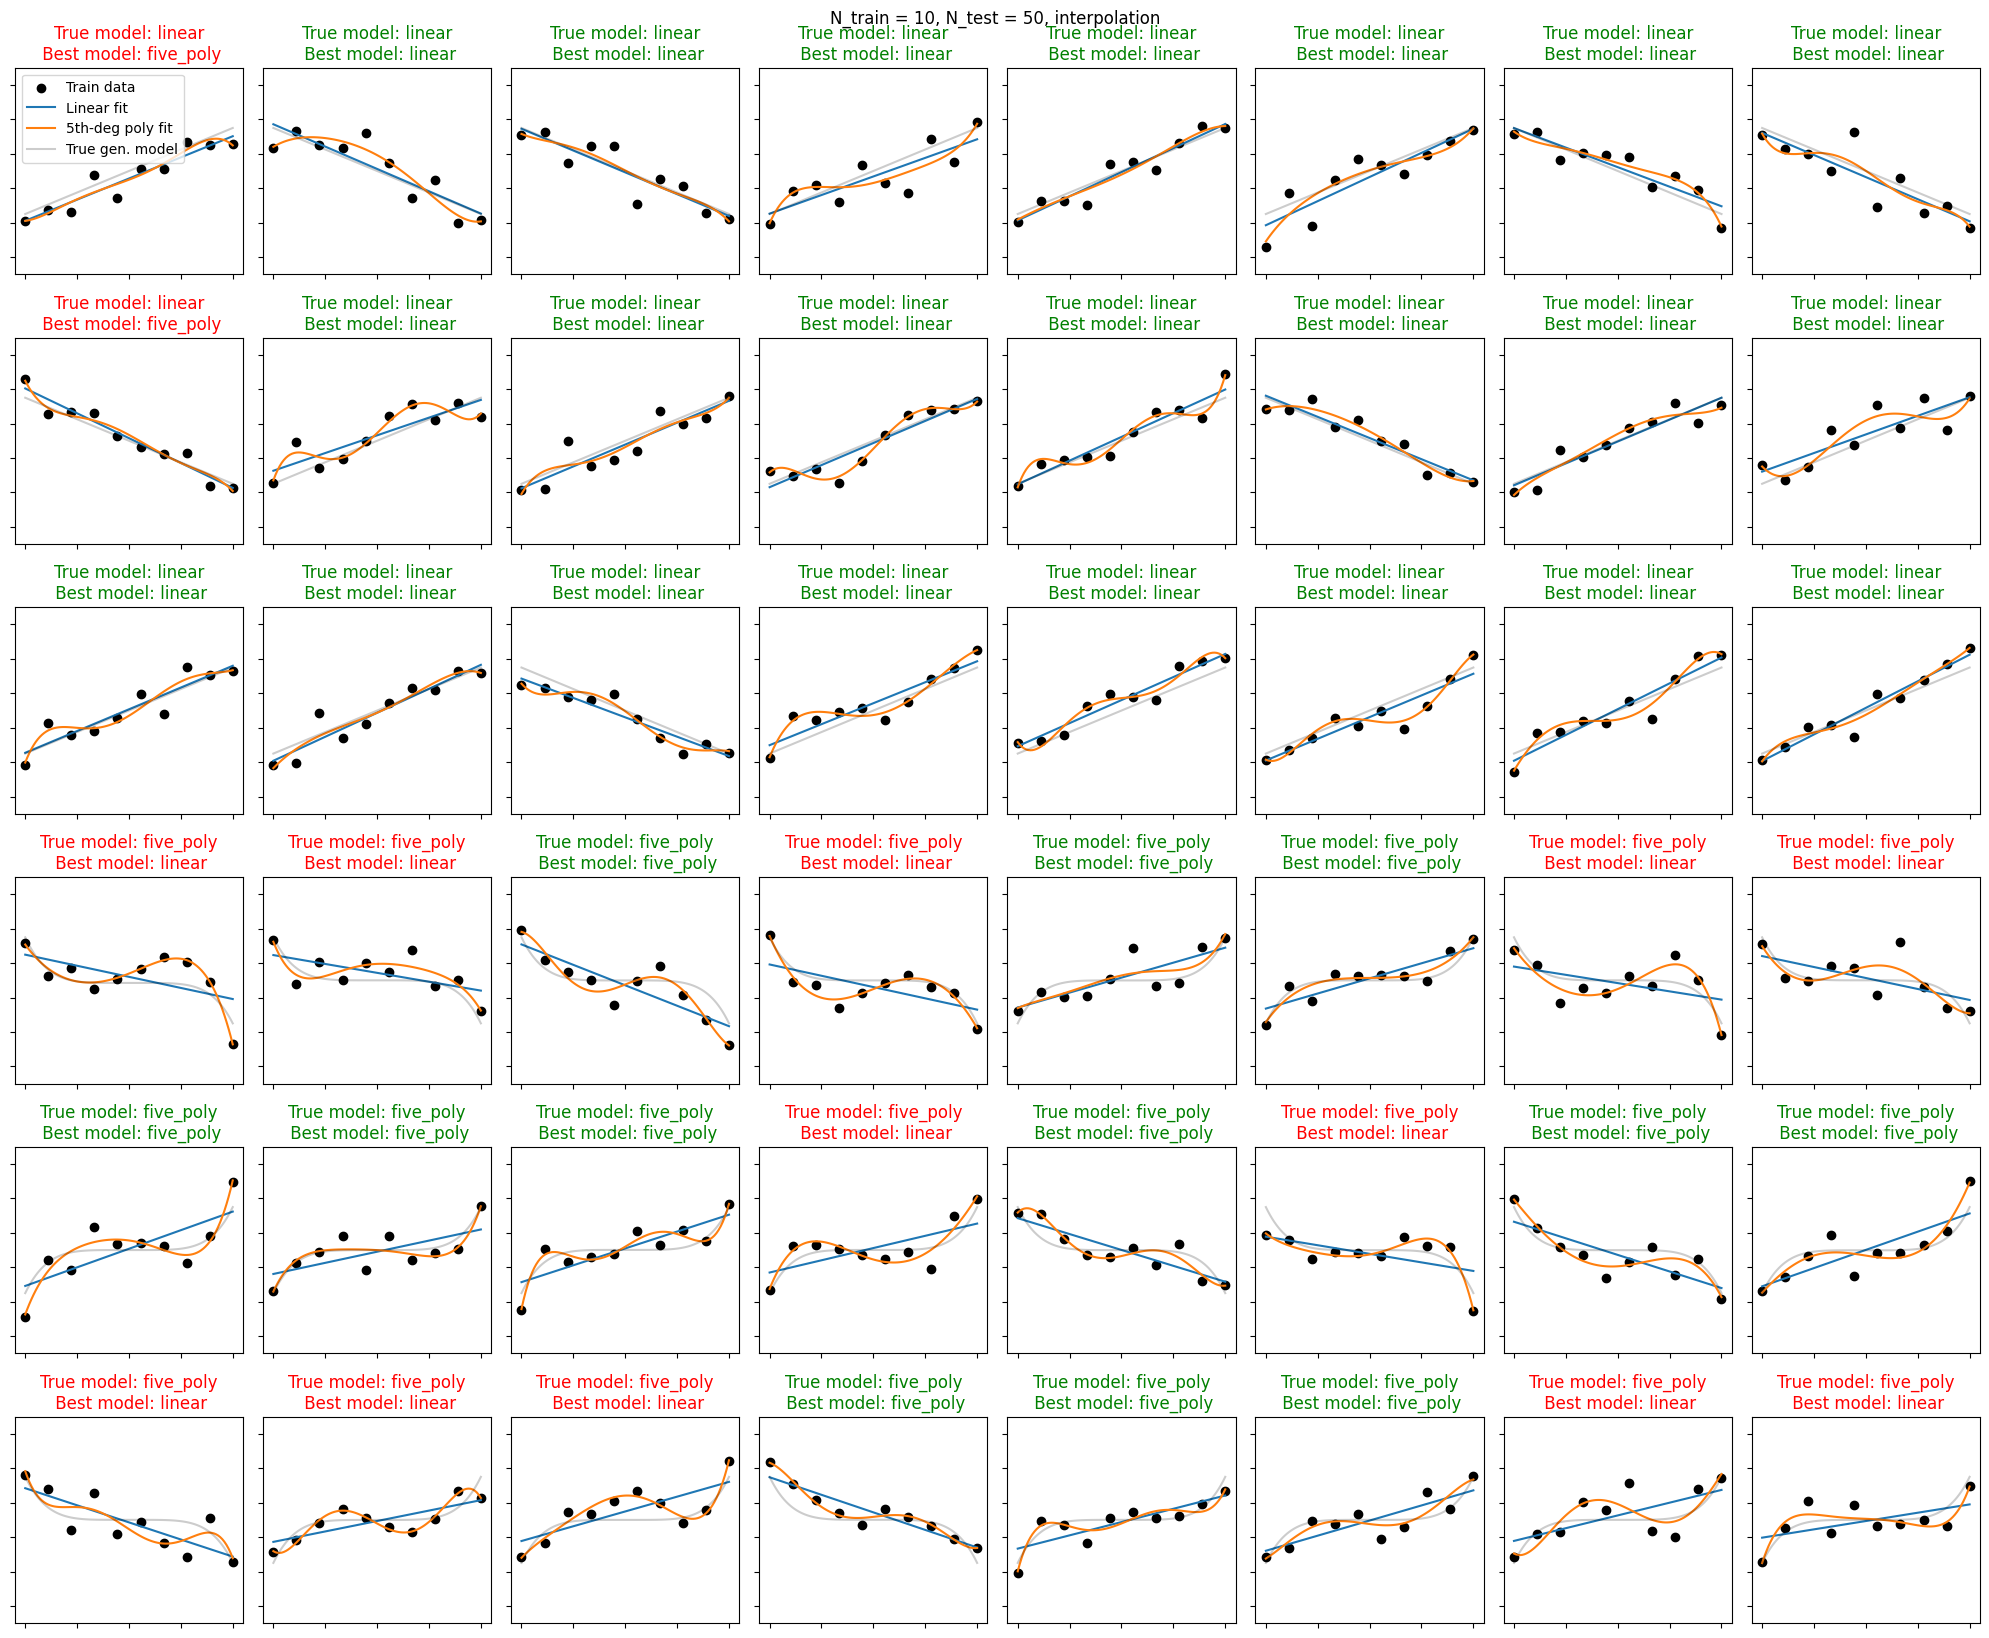

50 linear
50 five_poly


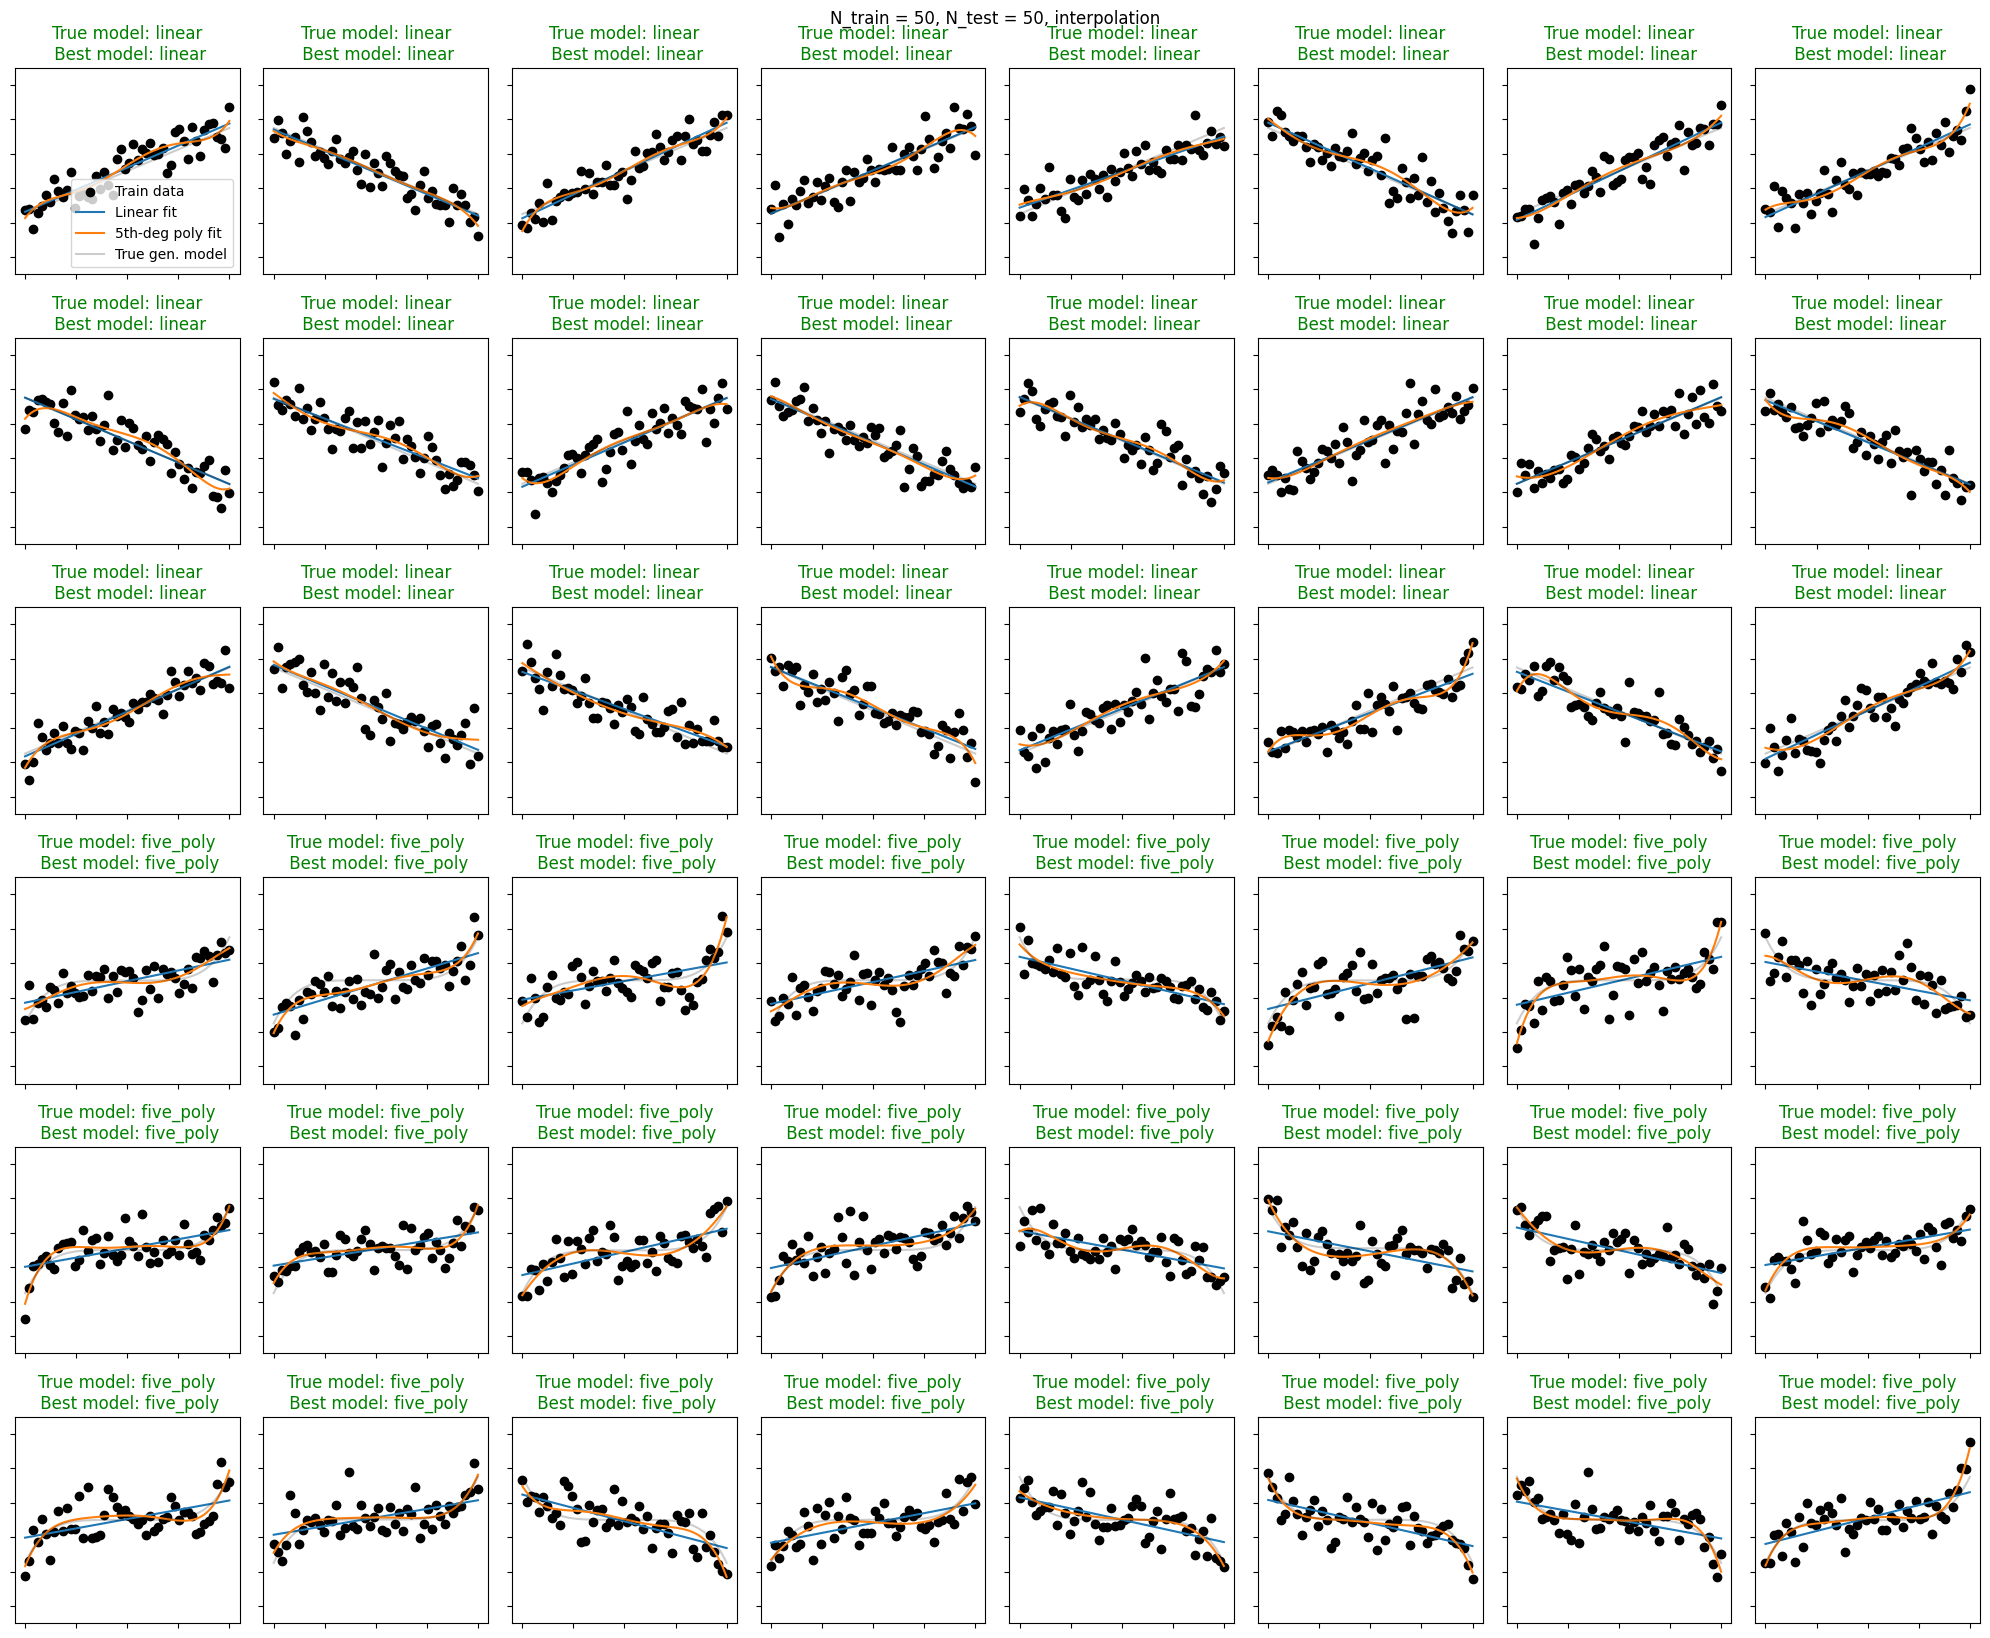

  ground_truth  trial  sample_size    param1    param2  param3  param4  \
0       linear      1           10  0.976270  4.303787     NaN     NaN   
1       linear      2           10  2.360309 -1.424626     NaN     NaN   
2       linear      3           10  9.238728 -4.157049     NaN     NaN   
3       linear      4           10  5.927829  9.183332     NaN     NaN   
4       linear      5           10  0.499409  5.011900     NaN     NaN   

   param5  param6  linear_error  five_poly_error best_model  
0     NaN     NaN      0.008307         0.008189  five_poly  
1     NaN     NaN      0.006575         0.010607     linear  
2     NaN     NaN      0.006469         0.006606     linear  
3     NaN     NaN      0.007795         0.010618     linear  
4     NaN     NaN      0.006746         0.006923     linear  


In [4]:

# Reproducibility
np.random.seed(0)

# Settings
sample_sizes = [10, 50]
trials_per_condition = 24
training_range = [-1000, 1000]
noise_sd = {"linear": 0.08, "five_poly": 0.08} # Scale is the min and max of training datapoints
# test_range = [3000, 3500]
test_range = training_range
test_n = 50
families = ["linear", "five_poly"]

# Parameter generator
def generate_parameters(family):
    if family == "linear":
        return np.random.uniform(-10, 10, size=2)   # a, b
    elif family == "five_poly":
        return np.random.uniform(-10, 10, size=6)   # a, b, c, d, e, f

# Data‐generation
def generate_data(x, params, family):
    if (family == "linear"):
        return params[1] * x + params[0]
    elif (family=="five_poly"):
        # a x^5 + b x^4 + c x^3 + d x^2 + e x + f
        return (params[5]*x**5 + params[4]*x**4 + params[3]*x**3 +
                params[2]*x**2 + params[1]*x + params[0])

# Collect results
results = []
x_grid = np.linspace(min(np.min(training_range),np.min(test_range)), max(np.max(training_range),np.max(test_range)), 100)

n_rows=6
n_cols=8
for training_n in sample_sizes:
    fig, ax = plt.subplots(n_rows, n_cols,figsize=(20,20/3*2.5))
    subplot_count = 0
    
    for family in families:
        print(training_n, family)
        for trial_idx in range(1, trials_per_condition + 1):
            params = generate_parameters(family)
            # pad params to length 6 for uniform storage
            params_padded = np.pad(params, (0, 6 - len(params)), constant_values=np.nan)


            # Ground truth
            y_train_true_grid = generate_data(x_grid, params, family)
            
            # Training data (regular grid)
            x_train = np.linspace(training_range[0], training_range[1], training_n)
            #x_train = np.random.uniform(training_range[0], training_range[1], training_n)
            y_train_true = generate_data(x_train, params, family)
            
            # Test data (random)
            x_test = np.sort(np.random.uniform(test_range[0], test_range[1], size=test_n))
            y_test_true = generate_data(x_test, params, family)
            
            # Normalize the signal for noise addition.
            ymin, ymax = compute_norm_yminmax(y_train_true, a=0.25, b=0.75)
            y_train_true = (y_train_true - ymin)/(ymax-ymin)
            y_test_true = (y_test_true - ymin)/(ymax-ymin)
            y_train_true_grid = (y_train_true_grid - ymin)/(ymax-ymin)
            
            # Add noise
            y_train = y_train_true + np.random.normal(scale=noise_sd[family], size=training_n)
            y_test = y_test_true + np.random.normal(scale=noise_sd[family], size=test_n)
            
            # Fit linear model
            lin_model = LinearRegression().fit(x_train.reshape(-1,1), y_train)
            
            # Fit 5th‐degree polynomial
            poly_model = make_pipeline(
                PolynomialFeatures(degree=5, include_bias=False),
                LinearRegression()
            ).fit(x_train.reshape(-1,1), y_train)
            
#             # Predictions
#             pred_lin = lin_model.predict(x_test.reshape(-1,1))
#             pred_poly = poly_model.predict(x_test.reshape(-1,1))
            
#             # Compute errors
#             err_lin  = np.sum(np.abs(pred_lin  - y_test))
#             err_poly = np.sum(np.abs(pred_poly - y_test))
#             MSE_lin  = np.sum((pred_lin  - y_test)**2)
#             MSE_poly = np.sum((pred_poly - y_test)**2)
#             MSE_best = "linear" if MSE_lin < MSE_poly else "five_poly"
            
            
#             MAE_lin = expected_test_loss(params, family, lin_model, [ymin, ymax], sigma=noise_sd[family], loss_type="MAE")
#             MAE_poly = expected_test_loss(params, family, poly_model, [ymin, ymax], sigma=noise_sd[family], loss_type="MAE")
#             MAE_best = "linear" if MAE_lin < MAE_poly else "five_poly"
            MSE_lin = expected_test_loss(params, family, lin_model, [ymin, ymax], sigma=noise_sd[family], loss_type="MSE")
            MSE_poly = expected_test_loss(params, family, poly_model, [ymin, ymax], sigma=noise_sd[family], loss_type="MSE")
            MSE_best = "linear" if MSE_lin < MSE_poly else "five_poly"
            
            # Store results
            results.append({
                "ground_truth": family,
                "trial": trial_idx,
                "sample_size": training_n,
                "param1": params_padded[0],
                "param2": params_padded[1],
                "param3": params_padded[2],
                "param4": params_padded[3],
                "param5": params_padded[4],
                "param6": params_padded[5],
                "linear_error": MSE_lin,
                "five_poly_error": MSE_poly,
                "best_model": MSE_best
            })
            
            # Plot
            x_curve = np.linspace(training_range[0], test_range[1], 100)
            y_curve_lin  = lin_model.predict(x_curve.reshape(-1,1))
            y_curve_poly = poly_model.predict(x_curve.reshape(-1,1))
            
            ax[subplot_count//n_cols, subplot_count%n_cols].scatter(x_train, y_train, color="k", alpha=1, label="Train data")
            #ax[subplot_count//n_cols, subplot_count%n_cols].scatter(x_test,  y_test, color="r", marker="x", alpha=0.5, label="Test data")
            ax[subplot_count//n_cols, subplot_count%n_cols].plot(x_curve, y_curve_lin,  label="Linear fit")
            ax[subplot_count//n_cols, subplot_count%n_cols].plot(x_curve, y_curve_poly, label="5th‐deg poly fit")
            ax[subplot_count//n_cols, subplot_count%n_cols].plot(x_grid, y_train_true_grid, "k-", alpha=0.2, label="True gen. model")
            if(family==MSE_best):
                title_color = "g"
            else:
                title_color = "r"
            ax[subplot_count//n_cols, subplot_count%n_cols].set_title(f"True model: {family}\n Best model: {MSE_best}", color=title_color)
            #ax[subplot_count//n_cols, subplot_count%n_cols].set_xlim(training_range)
            ax[subplot_count//n_cols, subplot_count%n_cols].set_ylim(-0.1,1.1)
            ax[0,0].legend()
            ax[subplot_count//n_cols, subplot_count%n_cols].set_xticklabels([])
            ax[subplot_count//n_cols, subplot_count%n_cols].set_yticklabels([])
            subplot_count = subplot_count+1
    fig.suptitle("N_train = {0}, N_test = {1}, interpolation".format(training_n, test_n))
    fig.tight_layout()
    plt.savefig(os.path.join(figpath, "smallnoise_trials_full_n"+str(training_n)), dpi=200)
    plt.show()

# Convert to DataFrame if you want to inspect or save:
df_results = pd.DataFrame(results)
print(df_results.head())


10 linear
10 five_poly


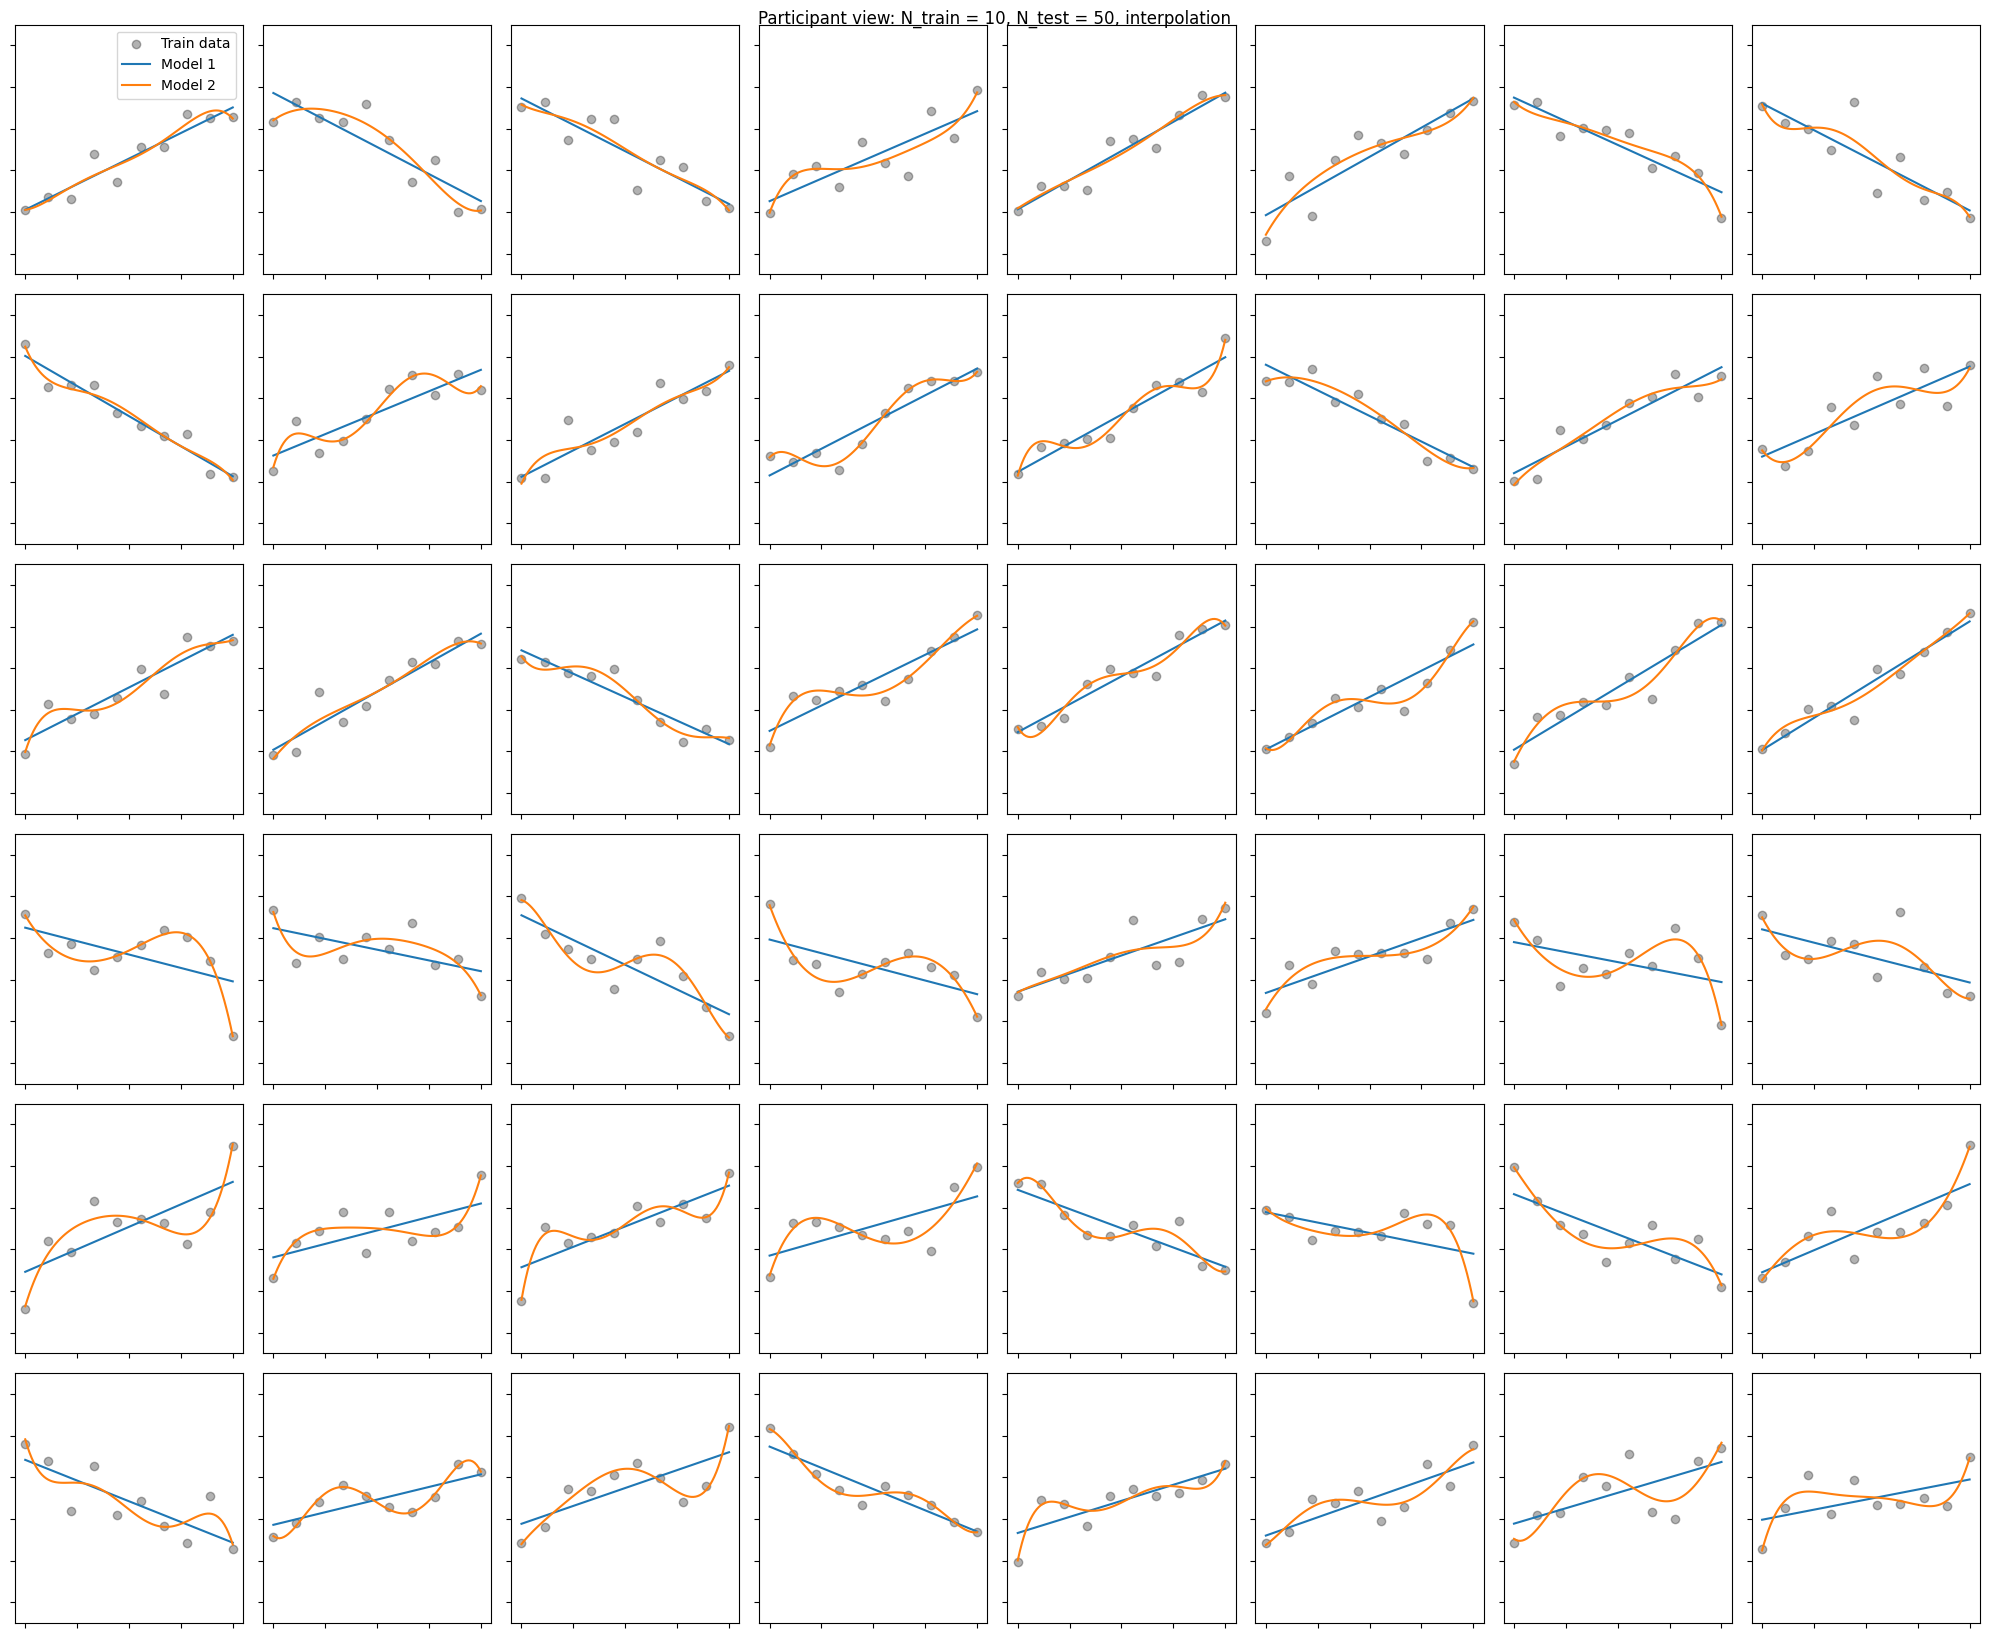

50 linear
50 five_poly


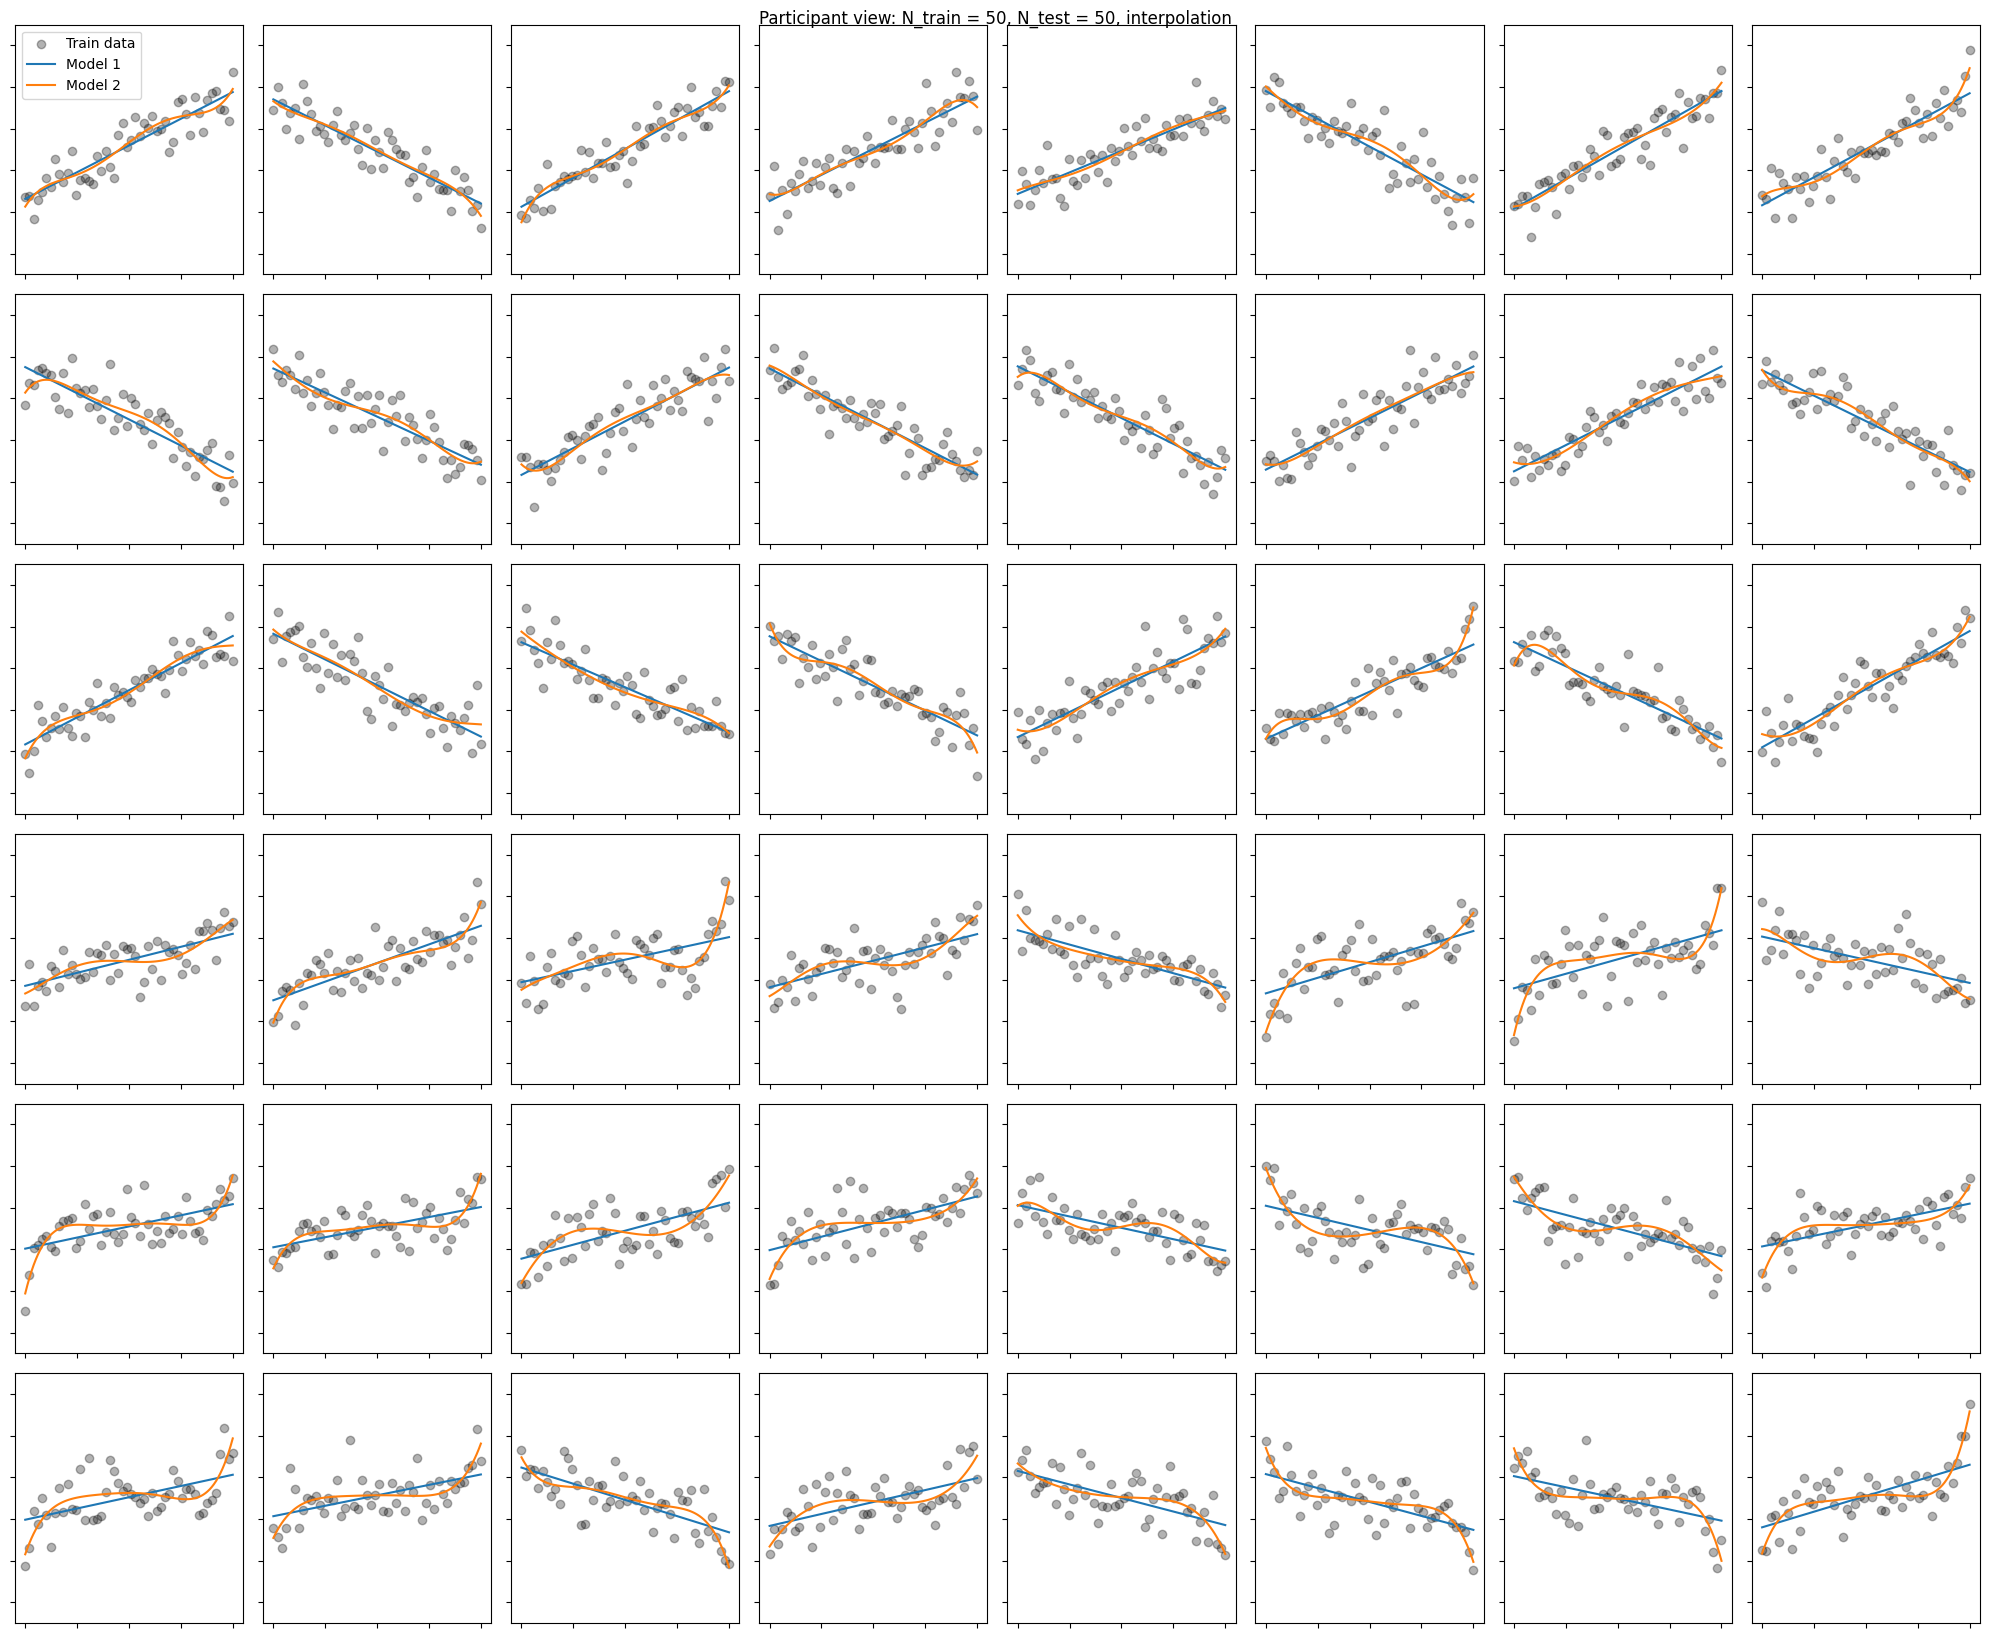

  ground_truth  trial  sample_size    param1    param2  param3  param4  \
0       linear      1           10  0.976270  4.303787     NaN     NaN   
1       linear      2           10  2.360309 -1.424626     NaN     NaN   
2       linear      3           10  9.238728 -4.157049     NaN     NaN   
3       linear      4           10  5.927829  9.183332     NaN     NaN   
4       linear      5           10  0.499409  5.011900     NaN     NaN   

   param5  param6  
0     NaN     NaN  
1     NaN     NaN  
2     NaN     NaN  
3     NaN     NaN  
4     NaN     NaN  


In [5]:
# How the stimuli would look like


# Reproducibility
np.random.seed(0)

# Settings
sample_sizes = [10, 50]
trials_per_condition = 24
training_range = [-1000, 1000]
noise_sd = {"linear": 0.08, "five_poly": 0.08} # Scale is the min and max of training datapoints
# test_range = [3000, 3500]
test_range = training_range
test_n = 50
families = ["linear", "five_poly"]

# Parameter generator
def generate_parameters(family):
    if family == "linear":
        return np.random.uniform(-10, 10, size=2)   # a, b
    elif family == "five_poly":
        return np.random.uniform(-10, 10, size=6)   # a, b, c, d, e, f

# Data‐generation
def generate_data(x, params, family):
    if (family == "linear"):
        return params[1] * x + params[0]
    elif (family=="five_poly"):
        # a x^5 + b x^4 + c x^3 + d x^2 + e x + f
        return (params[5]*x**5 + params[4]*x**4 + params[3]*x**3 +
                params[2]*x**2 + params[1]*x + params[0])

# Collect results
results = []
x_grid = np.linspace(min(np.min(training_range),np.min(test_range)), max(np.max(training_range),np.max(test_range)), 100)

n_rows=6
n_cols=8
for training_n in sample_sizes:
    fig, ax = plt.subplots(n_rows, n_cols,figsize=(20,20/3*2.5))
    subplot_count = 0
    
    if(training_n<=20):
        train_data_alpha = 0.3
    else:
        train_data_alpha = 0.3
    
    for family in families:
        print(training_n, family)
        for trial_idx in range(1, trials_per_condition + 1):
            params = generate_parameters(family)
            # pad params to length 6 for uniform storage
            params_padded = np.pad(params, (0, 6 - len(params)), constant_values=np.nan)


            # Ground truth
            y_train_true_grid = generate_data(x_grid, params, family)
            
            # Training data (regular grid)
            x_train = np.linspace(training_range[0], training_range[1], training_n)
            #x_train = np.random.uniform(training_range[0], training_range[1], training_n)
            y_train_true = generate_data(x_train, params, family)
            
            # Test data (random)
            x_test = np.sort(np.random.uniform(test_range[0], test_range[1], size=test_n))
            y_test_true = generate_data(x_test, params, family)
            
            # Normalize the signal for noise addition.
            ymin, ymax = compute_norm_yminmax(y_train_true, a=0.25, b=0.75)
        
            y_train_true = (y_train_true - ymin)/(ymax-ymin)
            y_test_true = (y_test_true - ymin)/(ymax-ymin)
            y_train_true_grid = (y_train_true_grid - ymin)/(ymax-ymin)
#             print(y_train_true.min(), y_train_true.max())
            
            # Add noise
            y_train = y_train_true + np.random.normal(scale=noise_sd[family], size=training_n)
            y_test = y_test_true + np.random.normal(scale=noise_sd[family], size=test_n)
            
            # Fit linear model
            lin_model = LinearRegression().fit(x_train.reshape(-1,1), y_train)
            
            # Fit 5th‐degree polynomial
            poly_model = make_pipeline(
                PolynomialFeatures(degree=5, include_bias=False),
                LinearRegression()
            ).fit(x_train.reshape(-1,1), y_train)
            
#             # Predictions
#             pred_lin = lin_model.predict(x_test.reshape(-1,1))
#             pred_poly = poly_model.predict(x_test.reshape(-1,1))
            
#             # Compute errors
# #             err_lin  = np.sum(np.abs(pred_lin  - y_test))
# #             err_poly = np.sum(np.abs(pred_poly - y_test))
#             err_lin  = np.sum((pred_lin  - y_test)**2)
#             err_poly = np.sum((pred_poly - y_test)**2)
#             best = "linear" if err_lin < err_poly else "five_poly"
            
#             # Store results
#             results.append({
#                 "ground_truth": family,
#                 "trial": trial_idx,
#                 "sample_size": training_n,
#                 "param1": params_padded[0],
#                 "param2": params_padded[1],
#                 "param3": params_padded[2],
#                 "param4": params_padded[3],
#                 "param5": params_padded[4],
#                 "param6": params_padded[5],
#                 "linear_error": err_lin,
#                 "five_poly_error": err_poly,
#                 "best_model": best
#             })
            
#             MAE_lin = expected_test_loss(params, family, lin_model, [ymin, ymax], sigma=noise_sd[family], loss_type="MAE")
#             MSE_lin = expected_test_loss(params, family, lin_model, [ymin, ymax], sigma=noise_sd[family], loss_type="MSE")
#             MAE_poly = expected_test_loss(params, family, poly_model, [ymin, ymax], sigma=noise_sd[family], loss_type="MAE")
#             MSE_poly = expected_test_loss(params, family, poly_model, [ymin, ymax], sigma=noise_sd[family], loss_type="MSE")
#             MAE_best = "linear" if MAE_lin < MAE_poly else "five_poly"
#             MSE_best = "linear" if MSE_lin < MSE_poly else "five_poly"
            
            # Store results
            results.append({
                "ground_truth": family,
                "trial": trial_idx,
                "sample_size": training_n,
                "param1": params_padded[0],
                "param2": params_padded[1],
                "param3": params_padded[2],
                "param4": params_padded[3],
                "param5": params_padded[4],
                "param6": params_padded[5],
#                 "linear_error": MSE_lin,
#                 "five_poly_error": MSE_poly,
#                 "best_model": MSE_best
            })
            
            # Plot
            x_curve = np.linspace(training_range[0], test_range[1], 100)
            y_curve_lin  = lin_model.predict(x_curve.reshape(-1,1))
            y_curve_poly = poly_model.predict(x_curve.reshape(-1,1))
            
            ax[subplot_count//n_cols, subplot_count%n_cols].scatter(x_train, y_train, color="k", alpha=train_data_alpha, label="Train data")
            #ax[subplot_count//n_cols, subplot_count%n_cols].scatter(x_test,  y_test, color="r", marker="x", alpha=0.5, label="Test data")
            ax[subplot_count//n_cols, subplot_count%n_cols].plot(x_curve, y_curve_lin,  label="Model 1")
            ax[subplot_count//n_cols, subplot_count%n_cols].plot(x_curve, y_curve_poly, label="Model 2")
            #ax[subplot_count//n_cols, subplot_count%n_cols].plot(x_grid, y_train_true_grid, "k-", alpha=0.2, label="True gen. model")
#             if(family==best):
#                 title_color = "g"
#             else:
#                 title_color = "r"
            #ax[subplot_count//n_cols, subplot_count%n_cols].set_title(f"True model: {family}\n Best model: {best}", color=title_color)
#             ax[subplot_count//n_cols, subplot_count%n_cols].set_xlim(training_range)
            ymin = y_train.min() #- 1*np.abs(y_train.min())
            ymax = y_train.max() #+ 1*np.abs(y_train.min())
#             ymin = min(y_train.min(), y_test.min()) - 1*np.abs(min(y_train.min(), y_test.min()))
#             ymax = max(y_train.max(), y_test.max()) + 1*np.abs(max(y_train.max(), y_test.max()))
            ax[subplot_count//n_cols, subplot_count%n_cols].set_ylim(-0.1,1.1) 
            ax[0,0].legend()
            ax[subplot_count//n_cols, subplot_count%n_cols].set_xticklabels([])
            ax[subplot_count//n_cols, subplot_count%n_cols].set_yticklabels([])
            subplot_count = subplot_count+1
    fig.suptitle("Participant view: N_train = {0}, N_test = {1}, interpolation".format(training_n, test_n))
    fig.tight_layout()
    plt.savefig(os.path.join(figpath, "smallnoise_trials_display_n"+str(training_n)), dpi=200)
    plt.show()

# Convert to DataFrame if you want to inspect or save:
df_results = pd.DataFrame(results)
print(df_results.head())


## Stimulus generation

In [6]:
def arrowed_spines(fig, ax, xlims, ylims):
    xmin, xmax = xlims
    ymin, ymax = ylims

    # removing the default axis on all sides:
#     for side in ['bottom','right','top','left']:
    for side in ['right','top']:
        ax.spines[side].set_visible(False)


    # get width and height of axes object to compute 
    # matching arrowhead length and width
    dps = fig.dpi_scale_trans.inverted()
    bbox = ax.get_window_extent().transformed(dps)
    width, height = bbox.width, bbox.height

    # manual arrowhead width and length
    hw = 1./30.*(ymax-ymin) 
    hl = 1./30.*(xmax-xmin)
    lw = 0 # axis line width
    ohg = 0.2 # arrow overhang

    # compute matching arrowhead length and width
    yhw = hw/(ymax-ymin)*(xmax-xmin)* height/width 
    yhl = hl/(xmax-xmin)*(ymax-ymin)* width/height

    # draw x and y axis
    ax.arrow(xlims[0], ylims[0], xlims[1]-xlims[0], 0., fc='k', ec='k', lw = lw, 
             head_width=hw, head_length=hl, overhang = ohg, 
             length_includes_head= True, clip_on = False) 

    ax.arrow(xlims[0], ylims[0], 0., ylims[1]-ylims[0], fc='k', ec='k', lw = lw, 
             head_width=yhw, head_length=yhl, overhang = ohg, 
             length_includes_head= True, clip_on = False)
    

    
    


10 linear


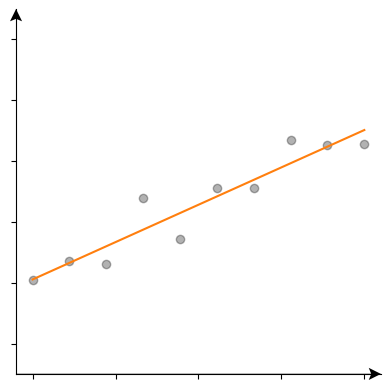

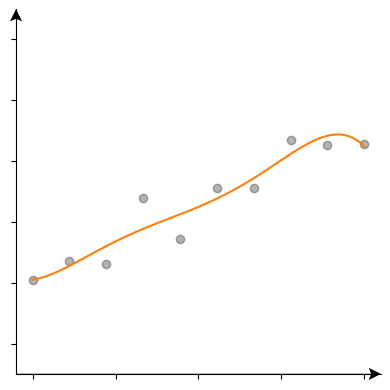

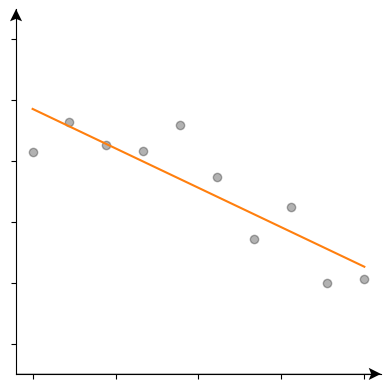

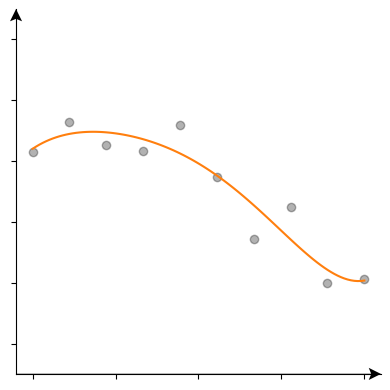

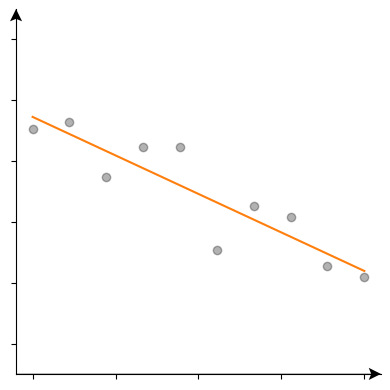

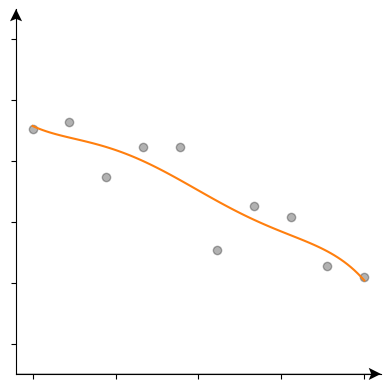

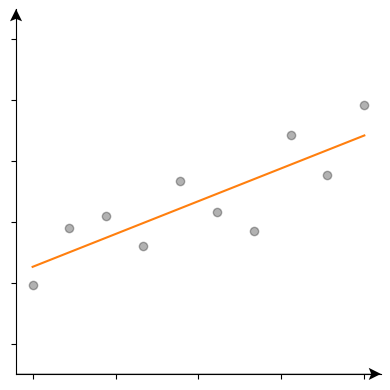

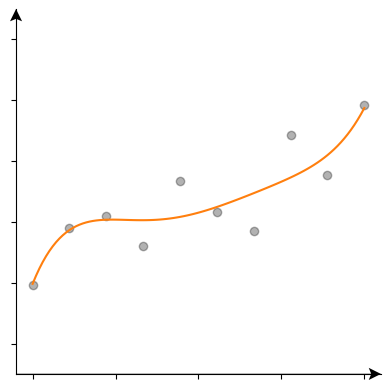

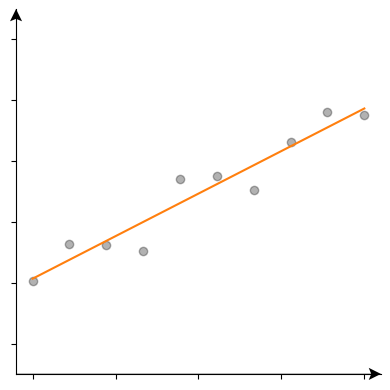

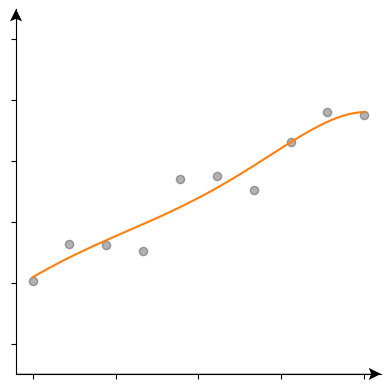

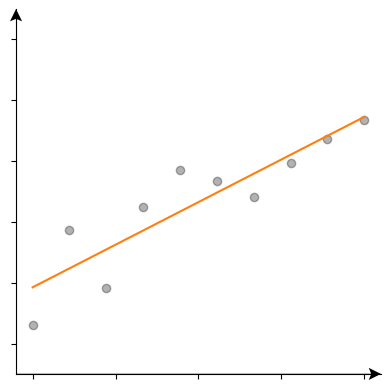

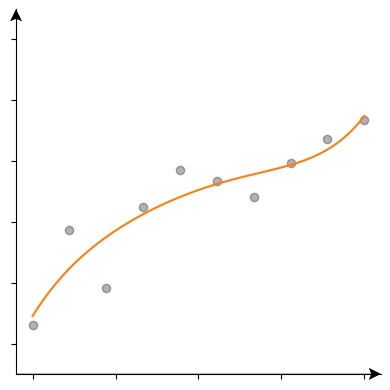

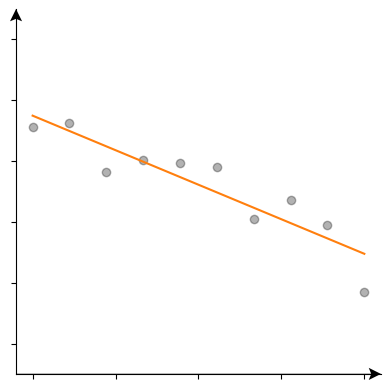

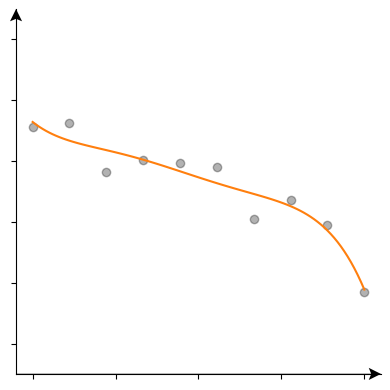

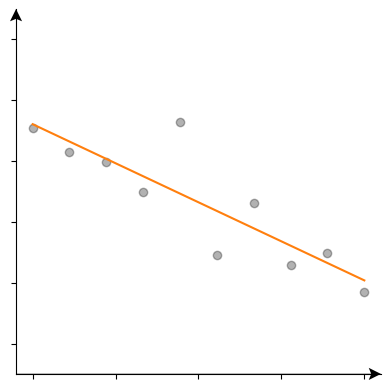

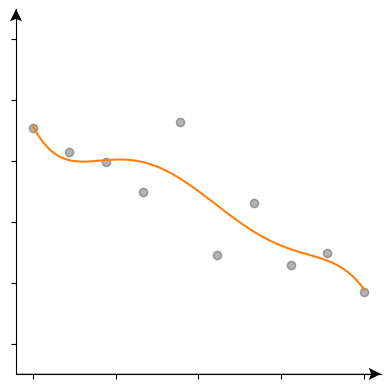

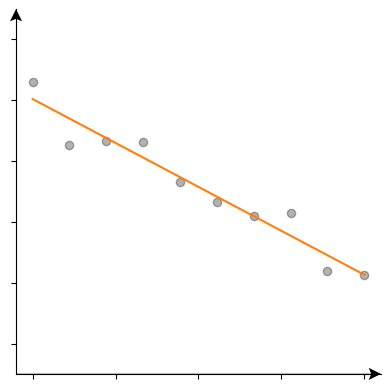

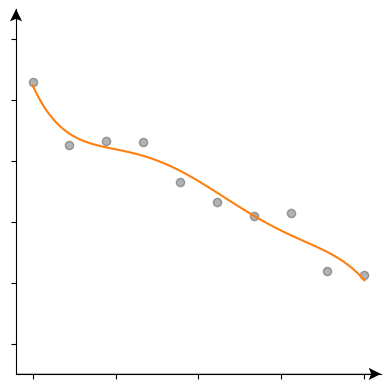

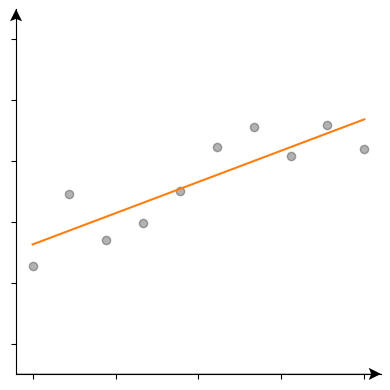

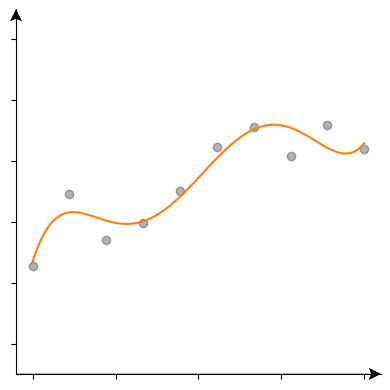

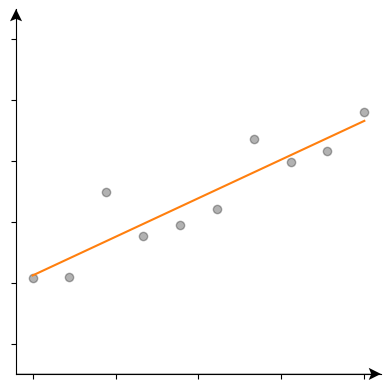

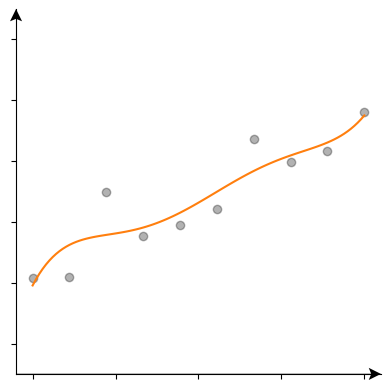

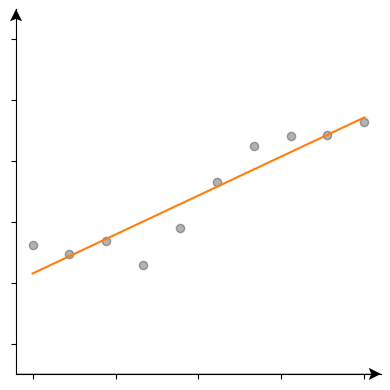

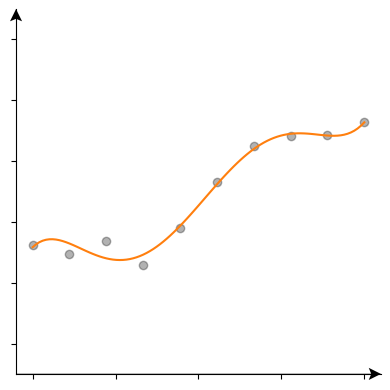

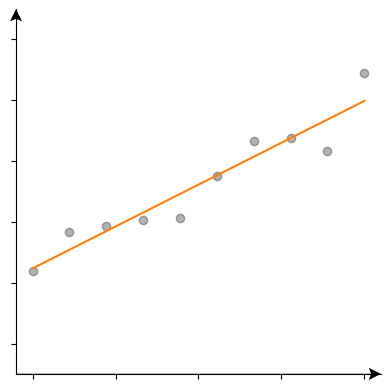

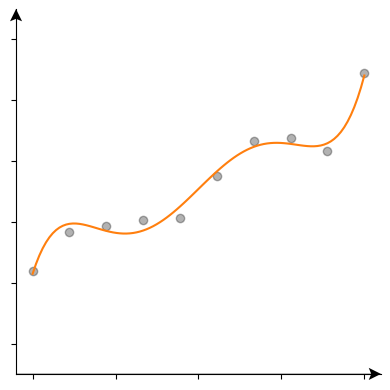

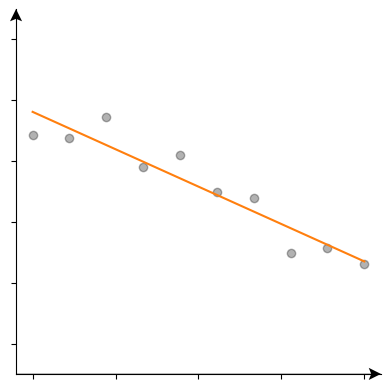

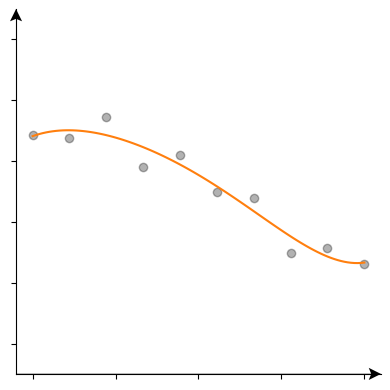

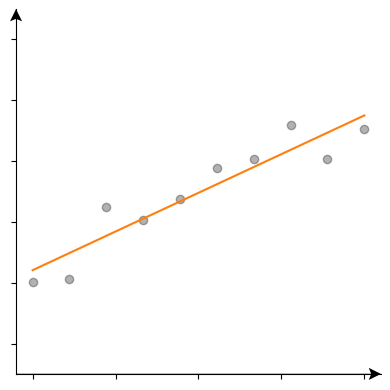

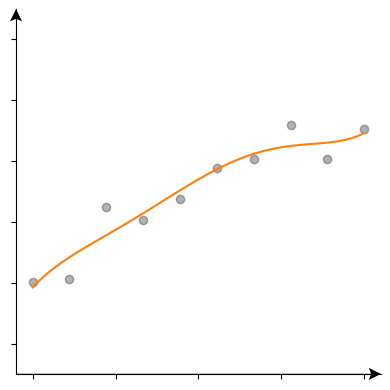

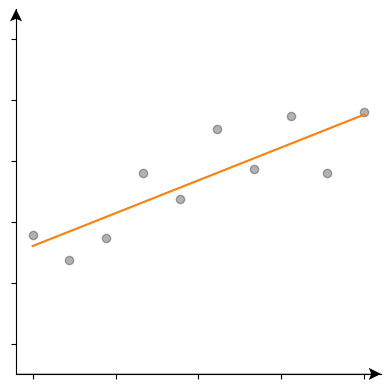

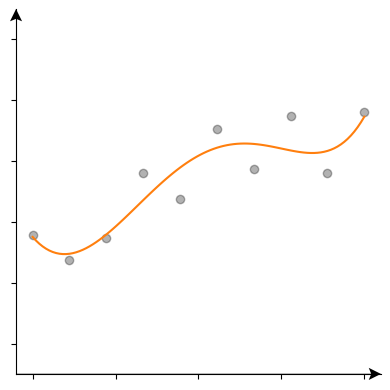

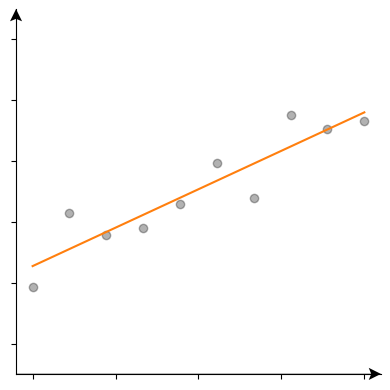

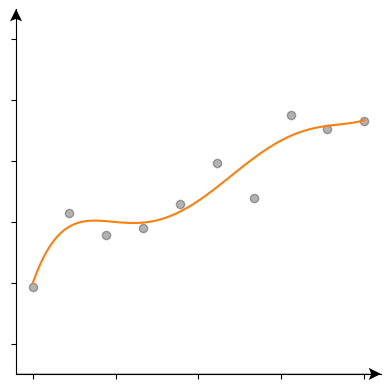

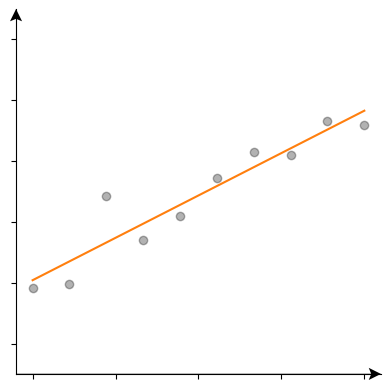

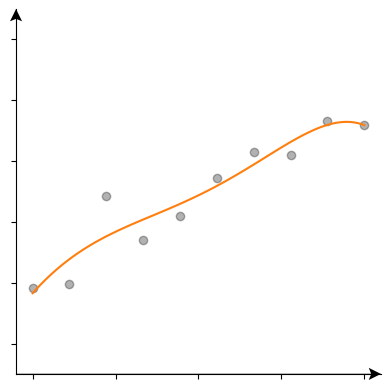

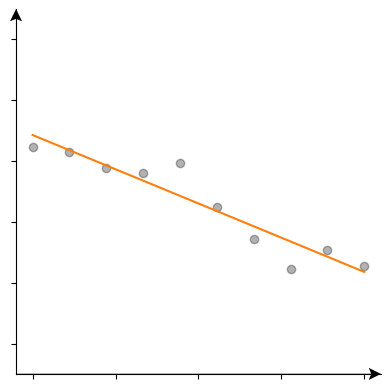

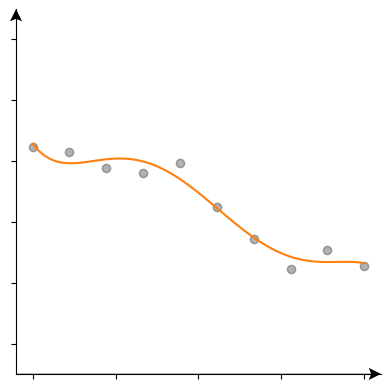

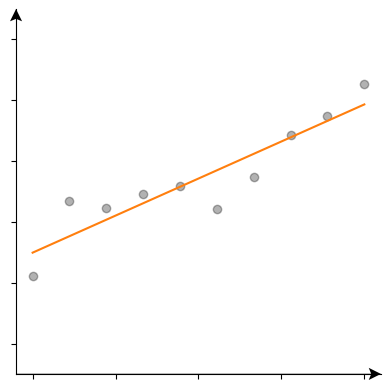

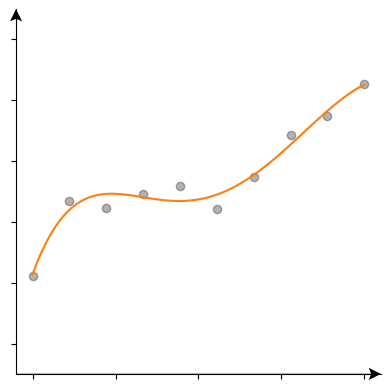

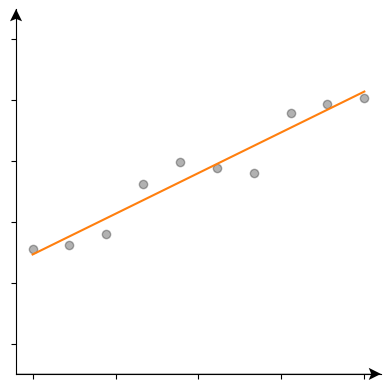

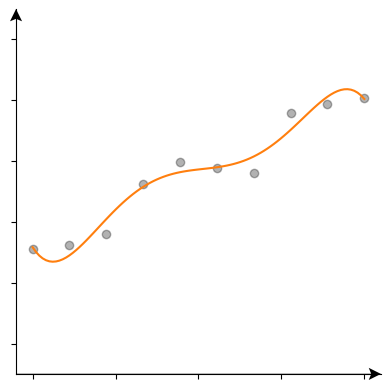

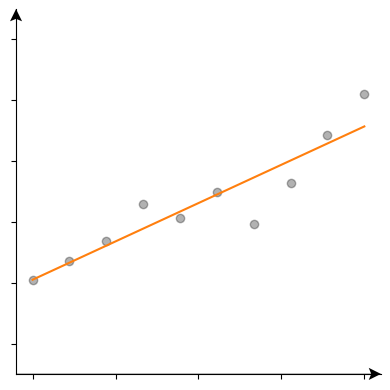

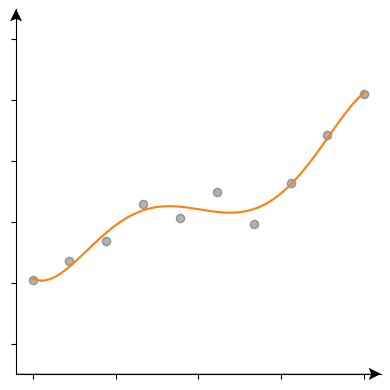

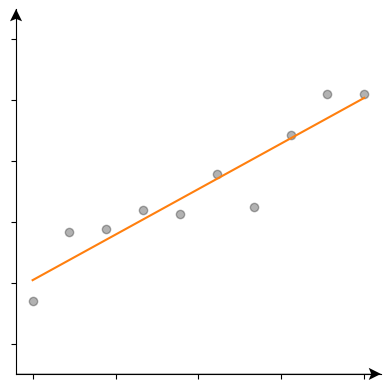

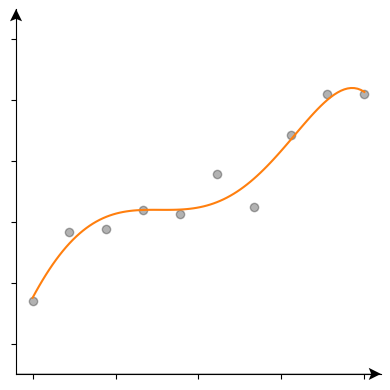

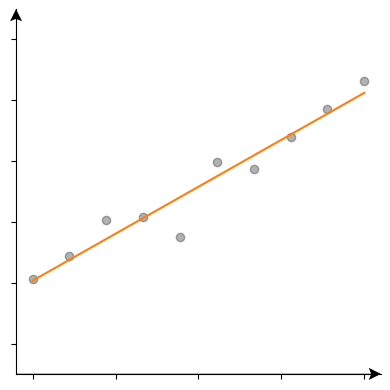

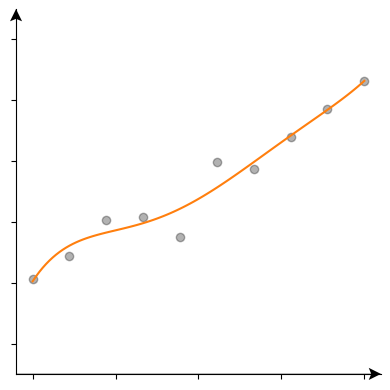

10 five_poly


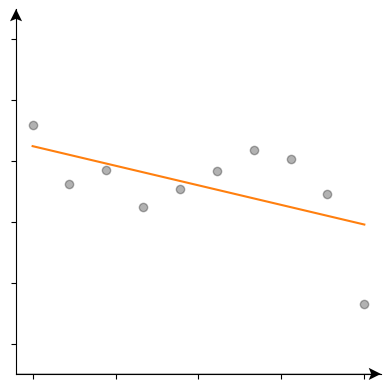

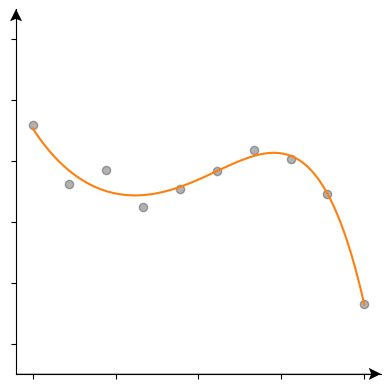

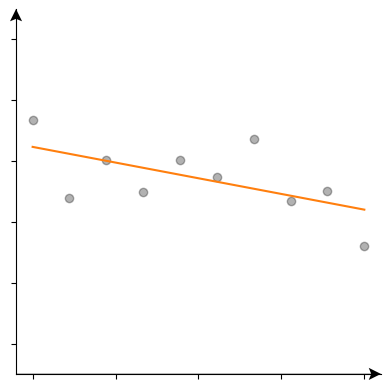

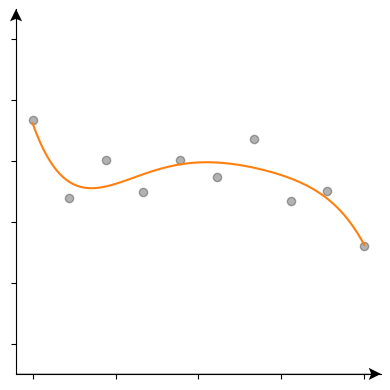

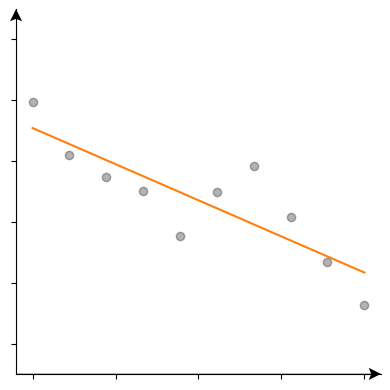

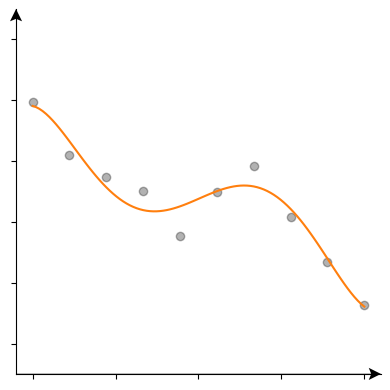

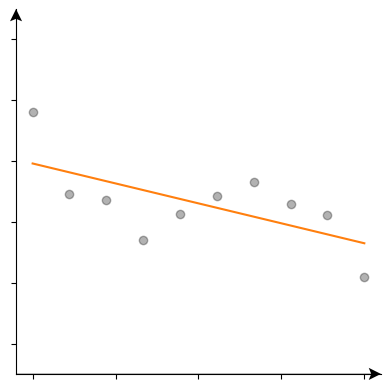

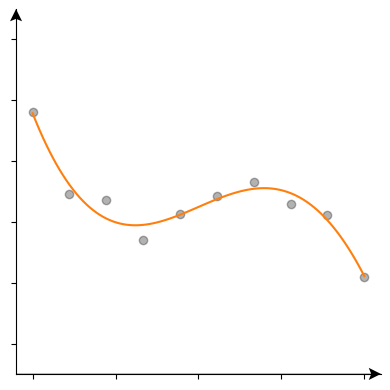

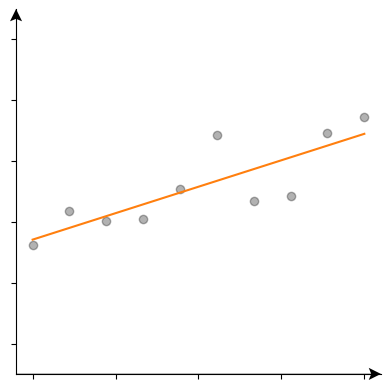

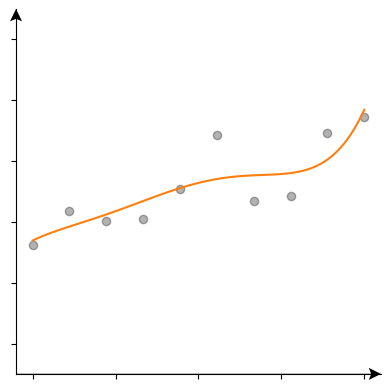

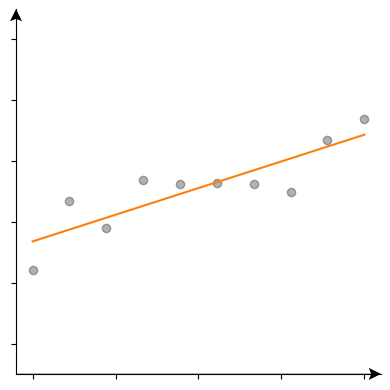

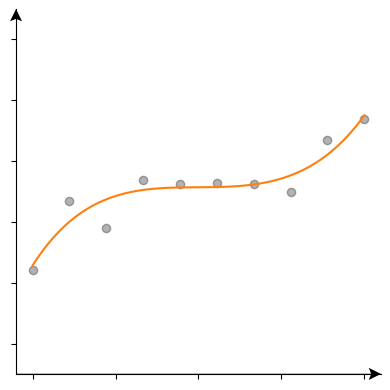

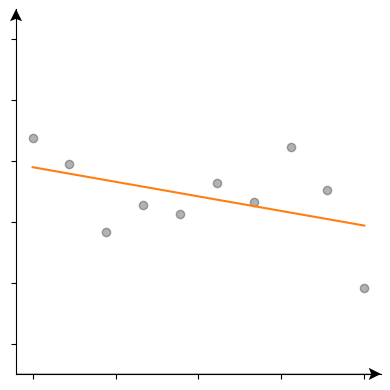

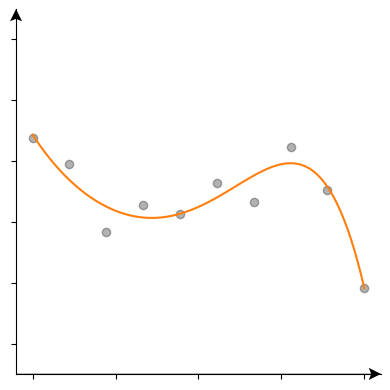

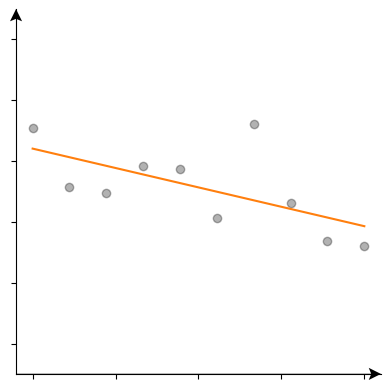

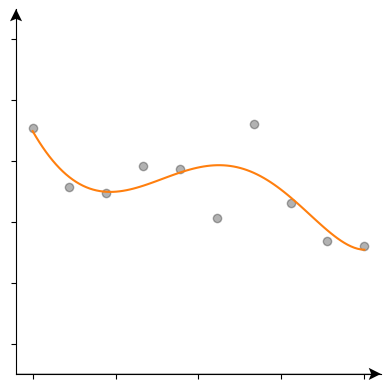

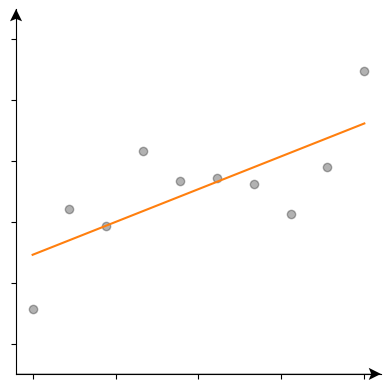

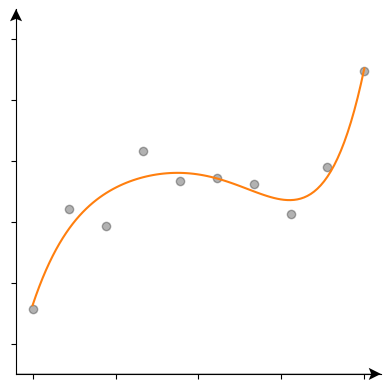

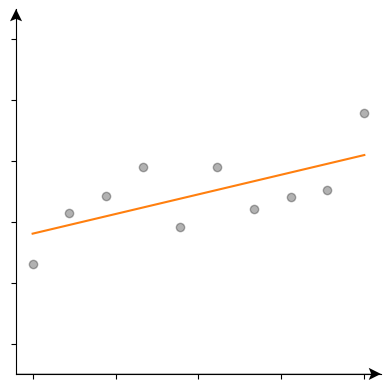

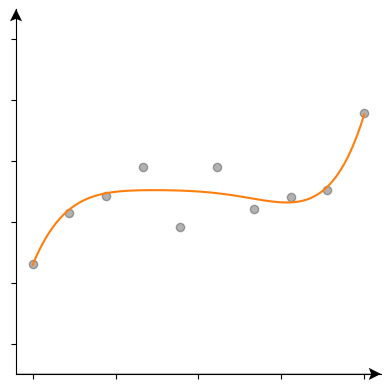

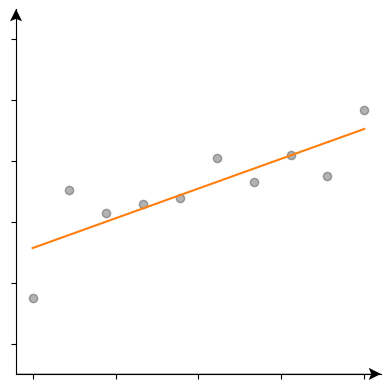

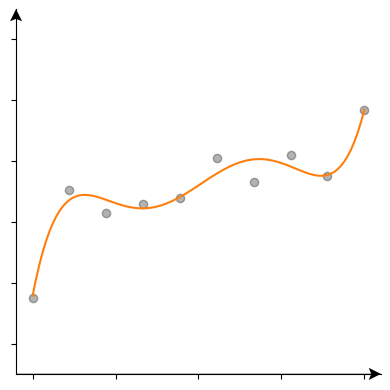

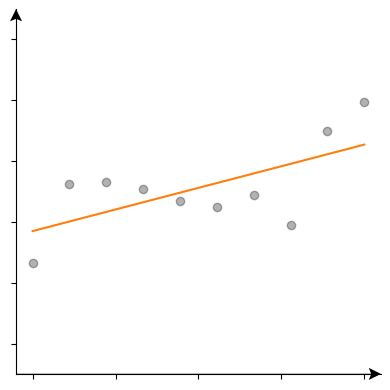

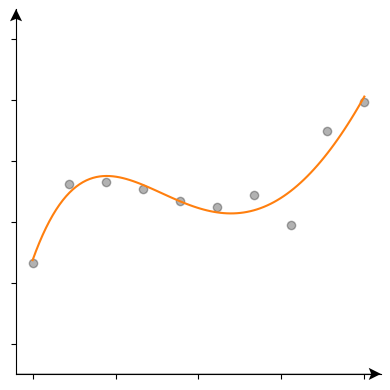

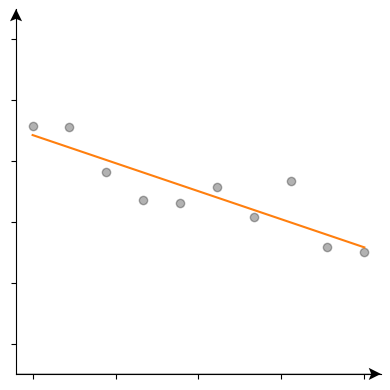

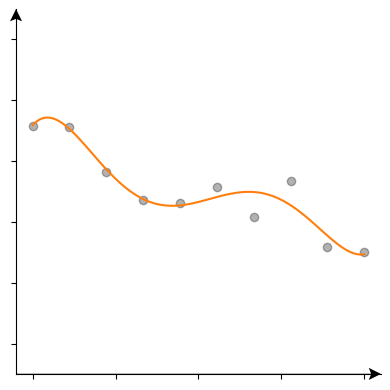

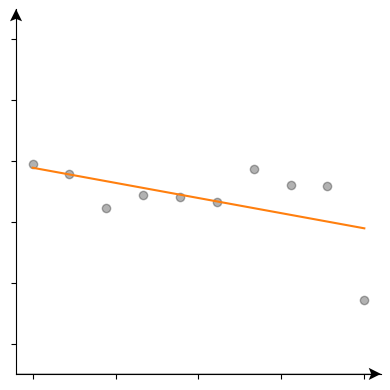

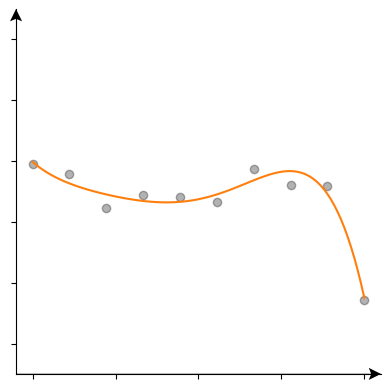

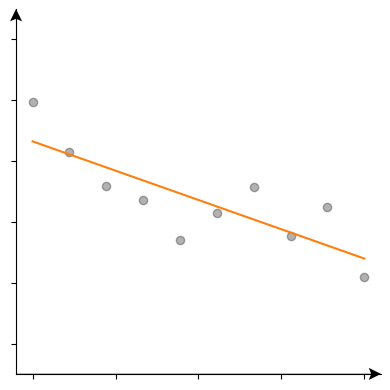

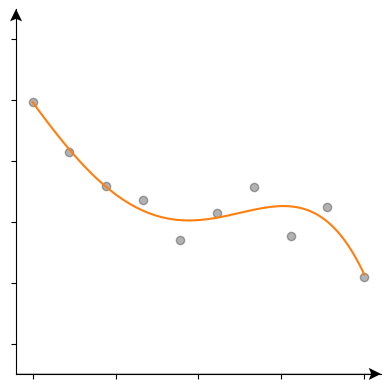

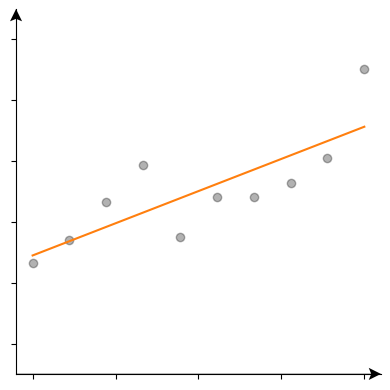

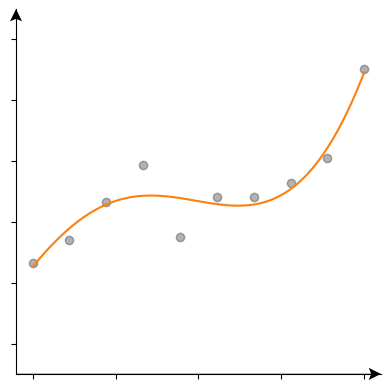

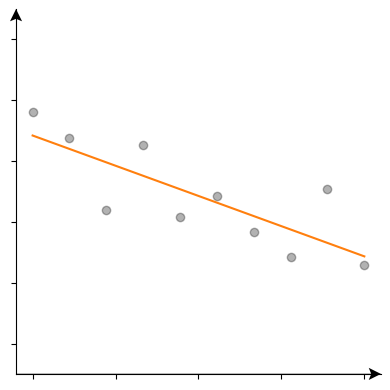

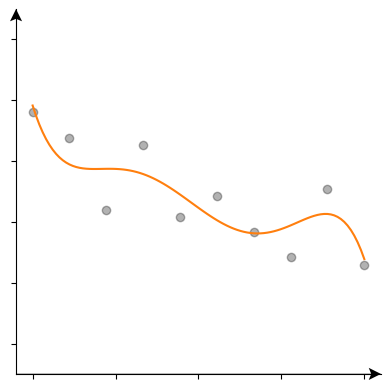

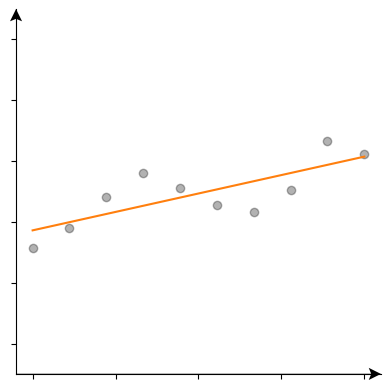

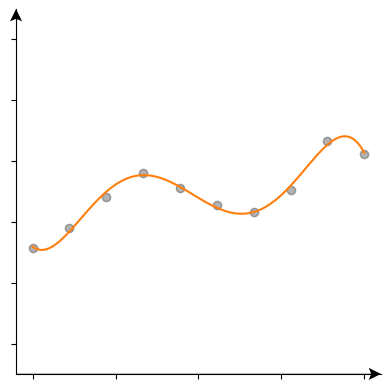

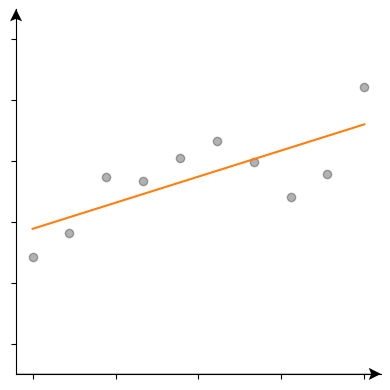

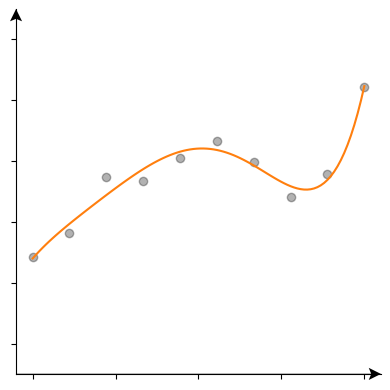

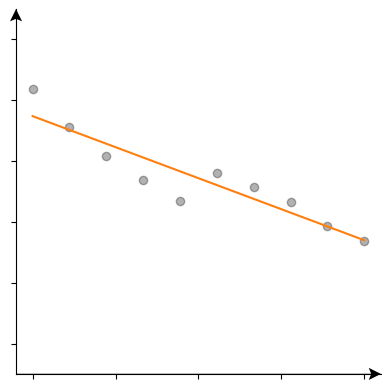

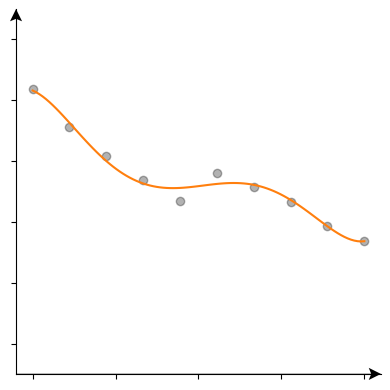

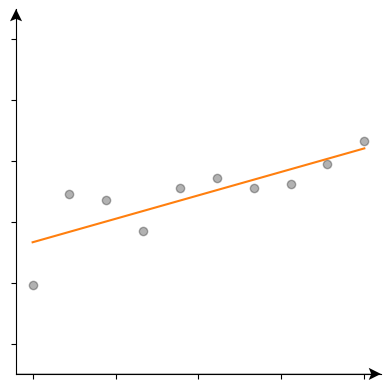

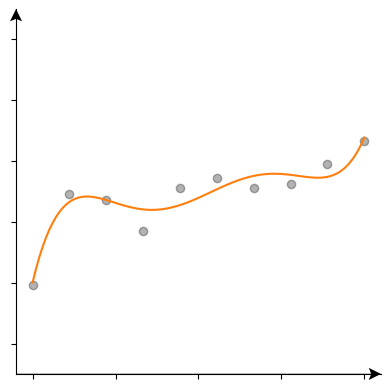

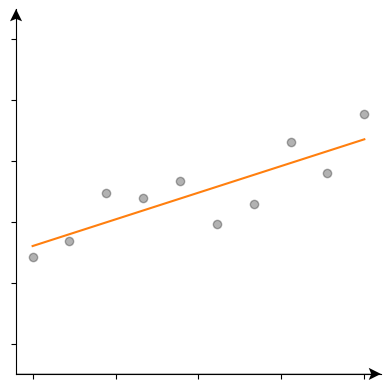

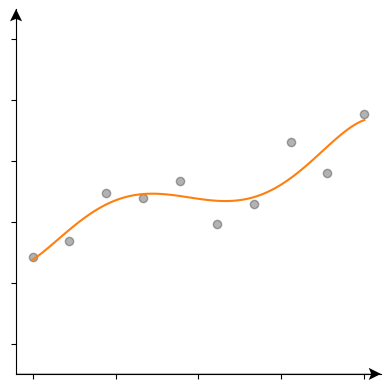

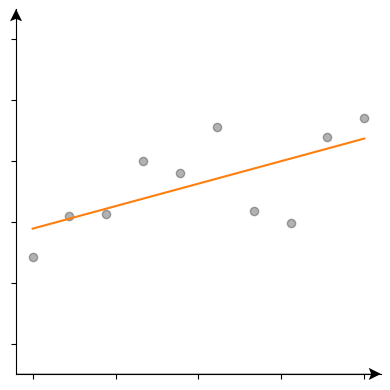

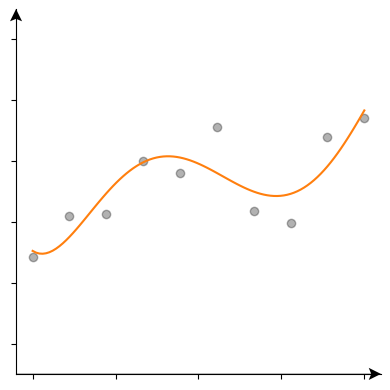

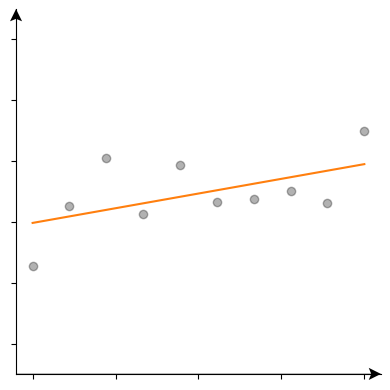

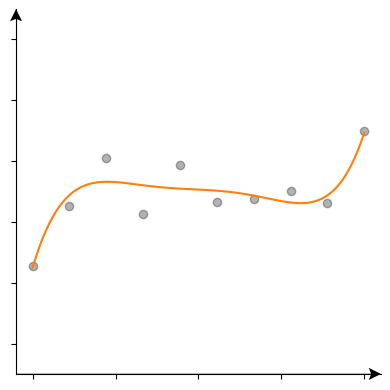

50 linear


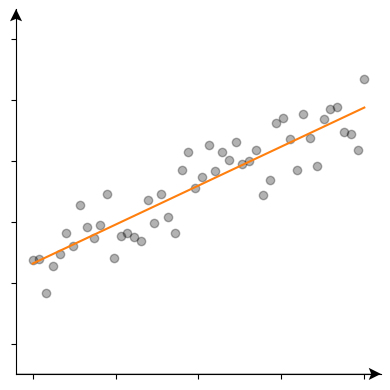

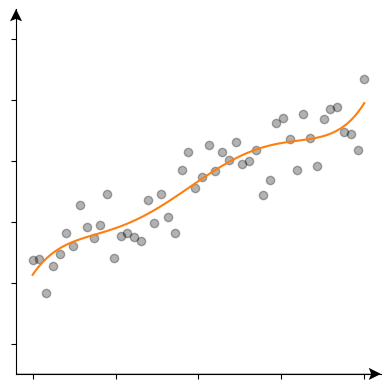

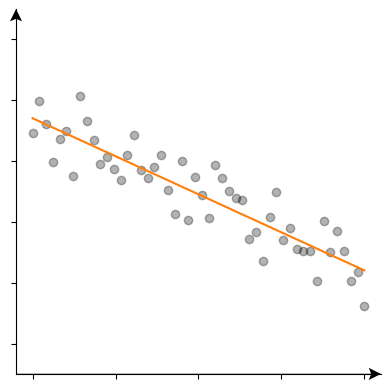

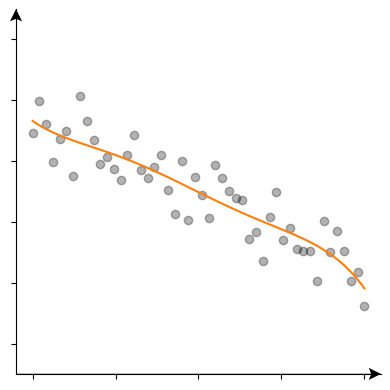

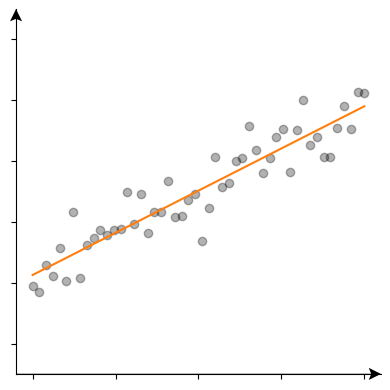

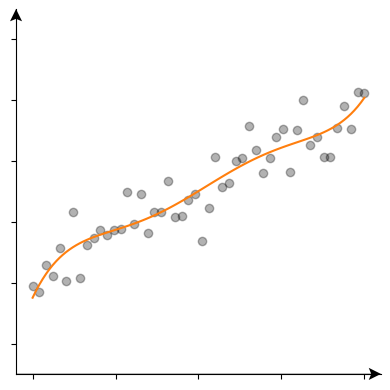

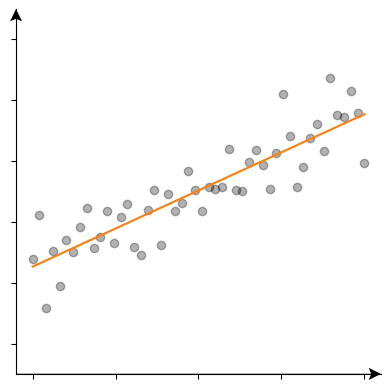

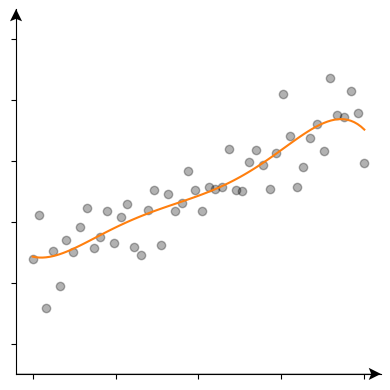

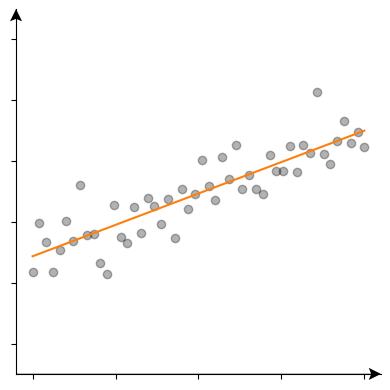

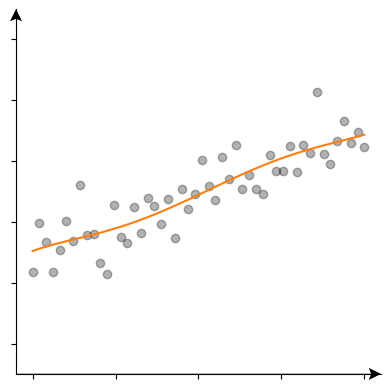

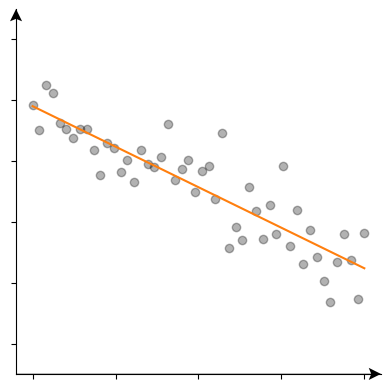

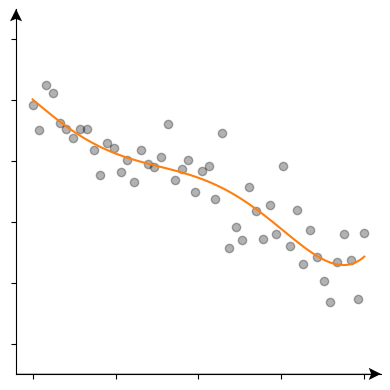

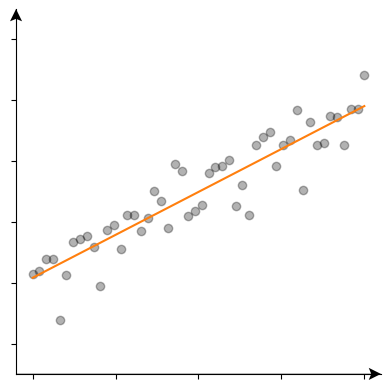

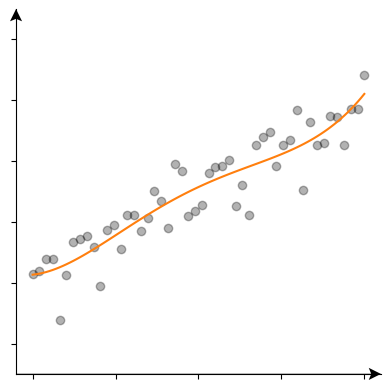

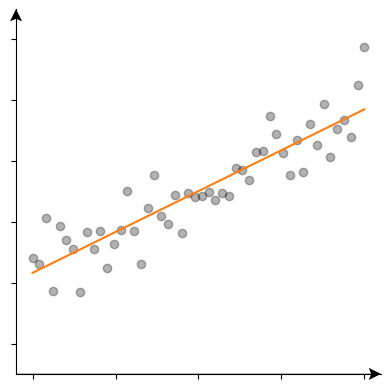

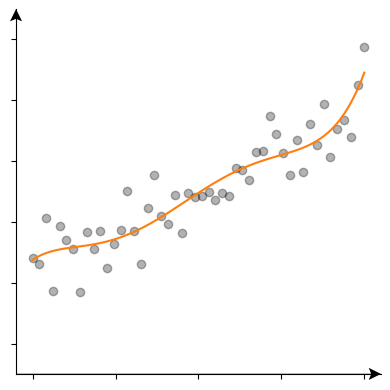

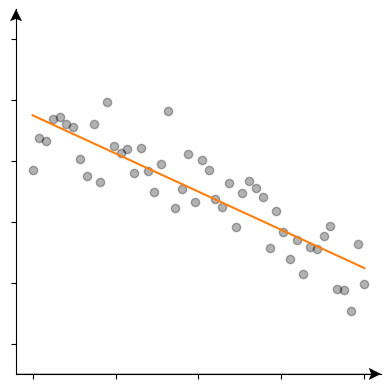

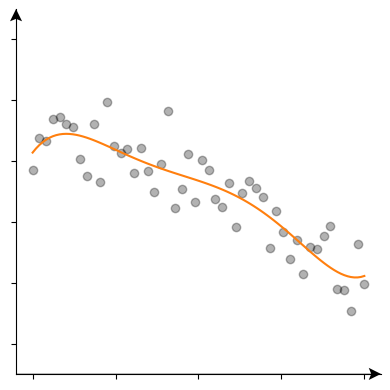

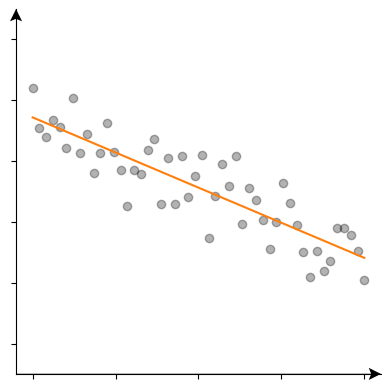

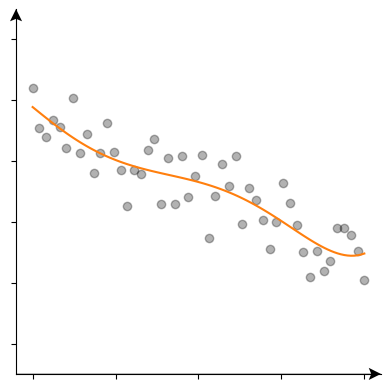

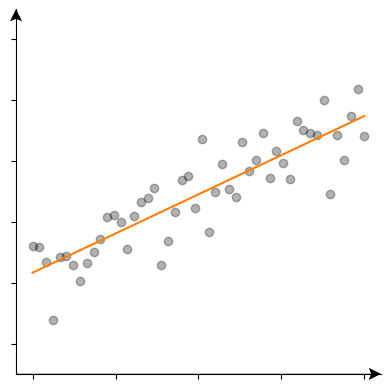

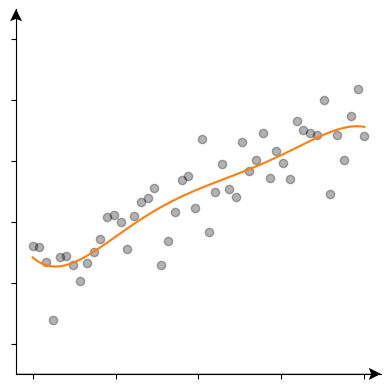

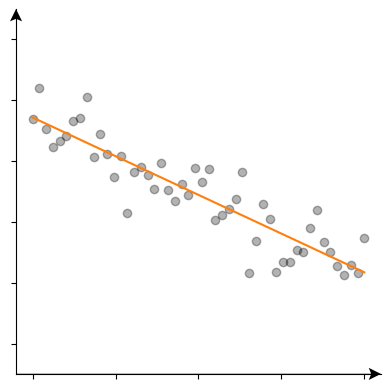

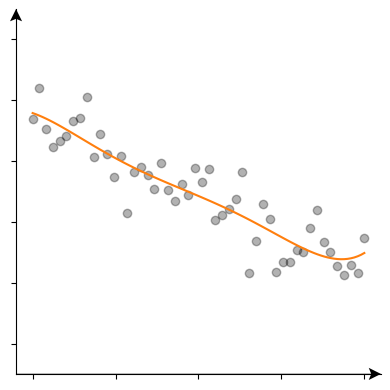

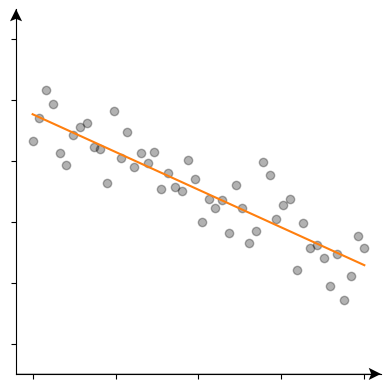

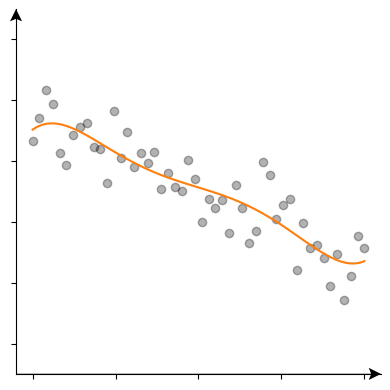

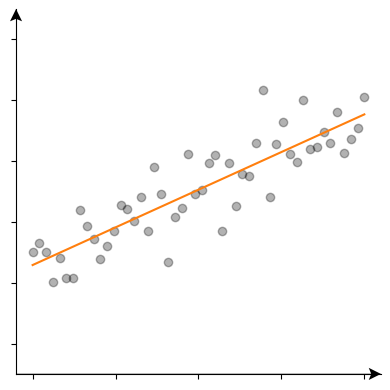

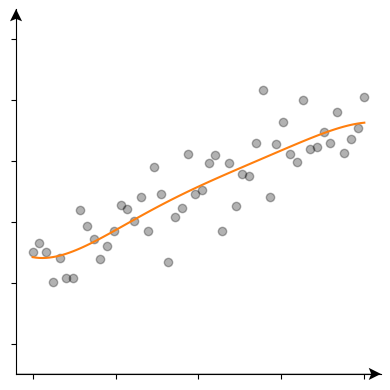

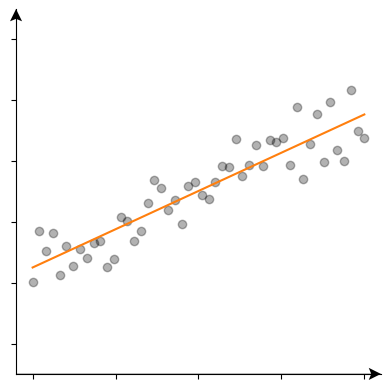

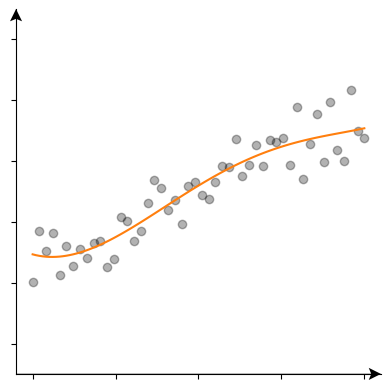

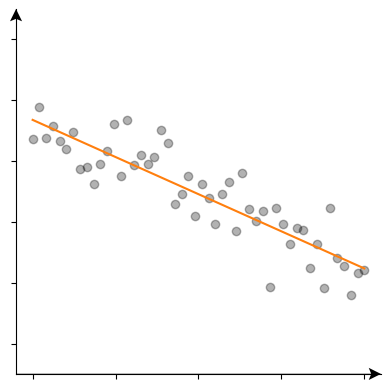

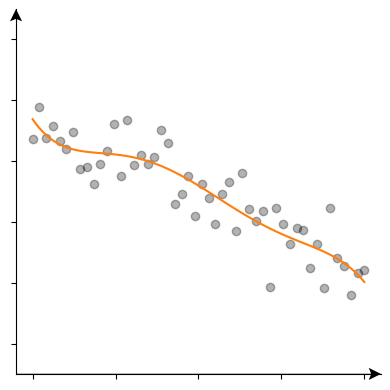

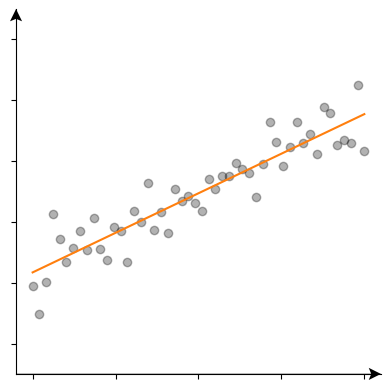

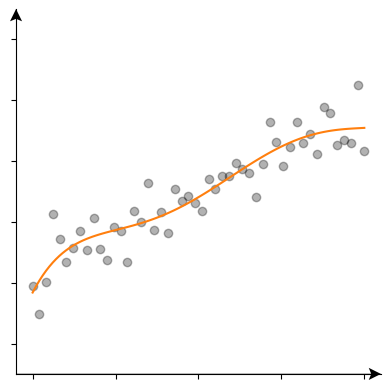

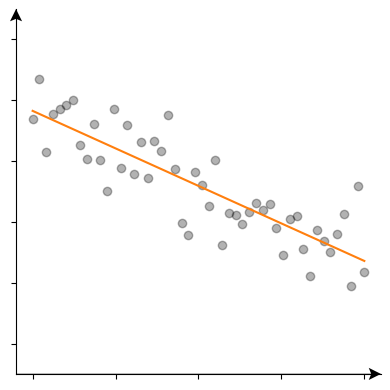

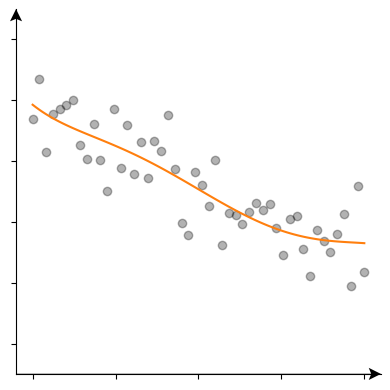

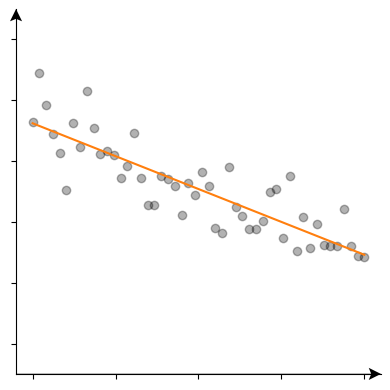

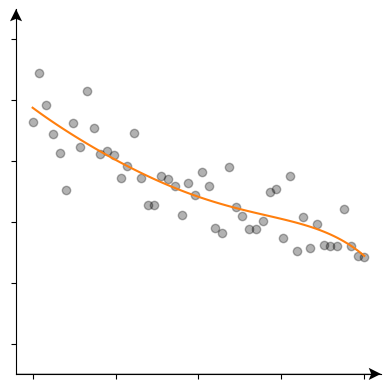

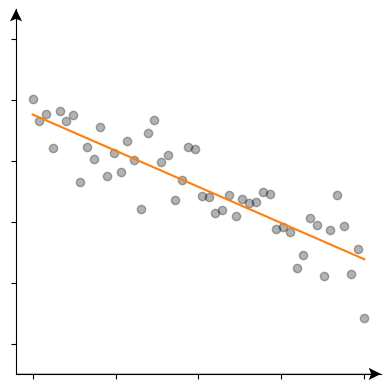

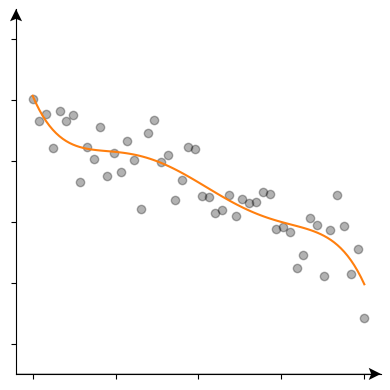

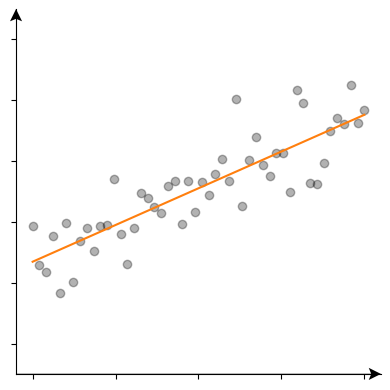

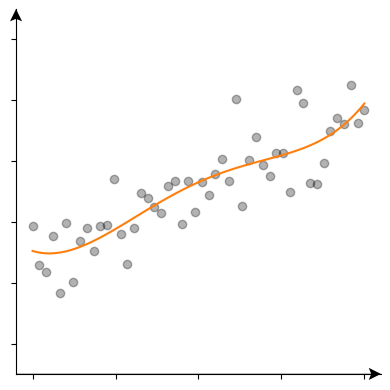

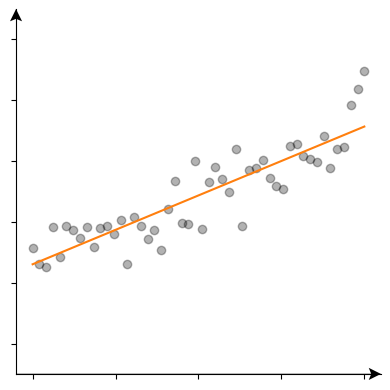

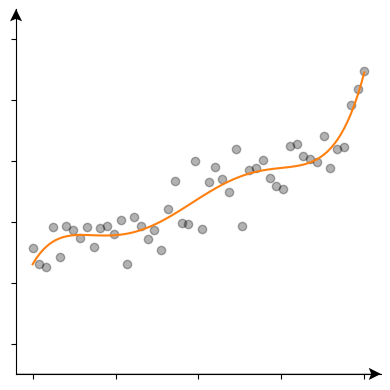

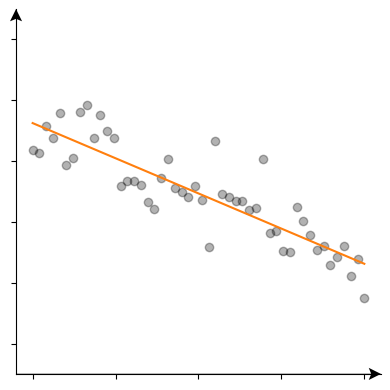

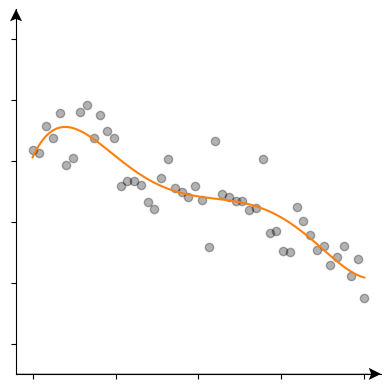

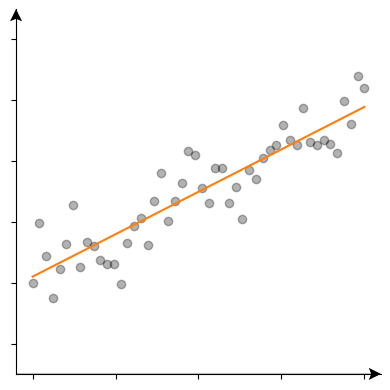

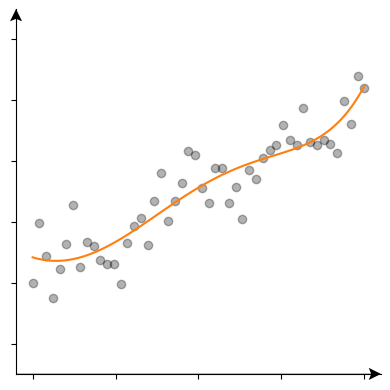

50 five_poly


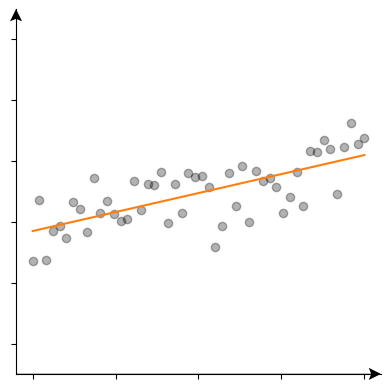

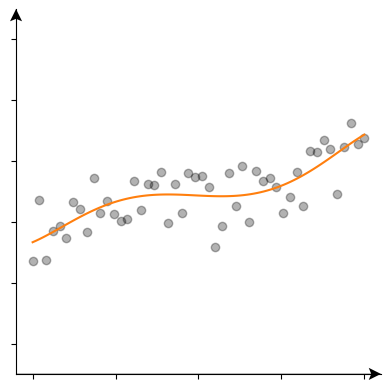

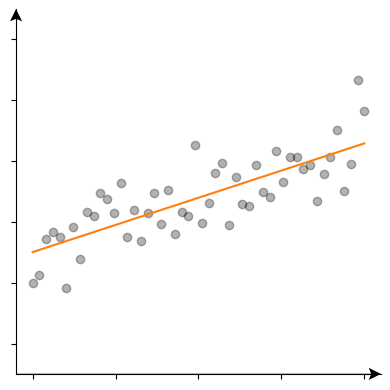

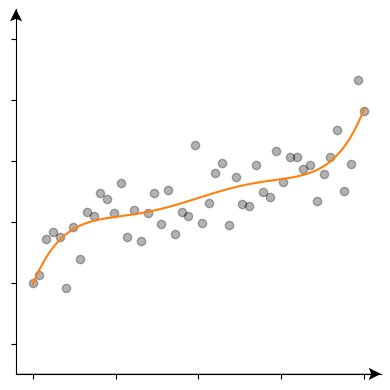

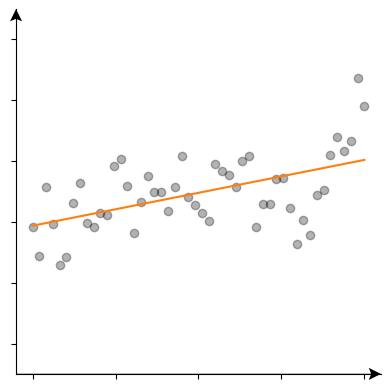

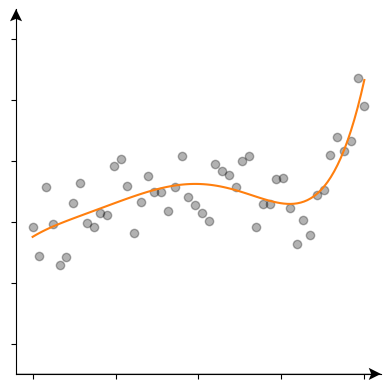

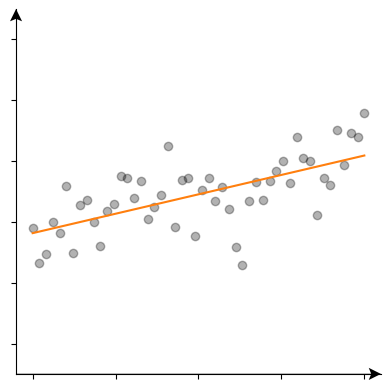

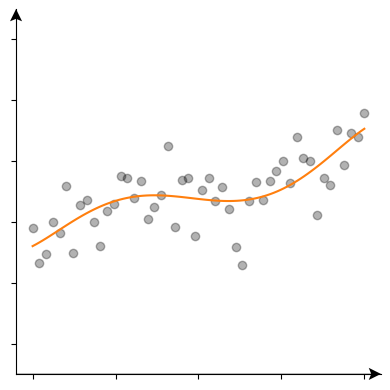

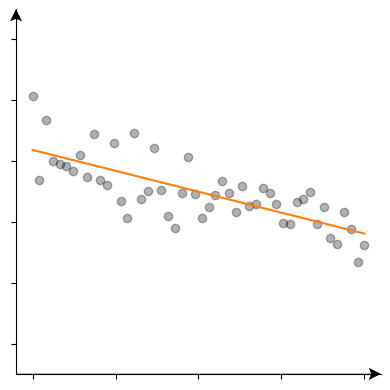

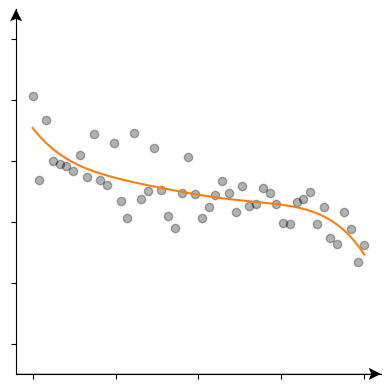

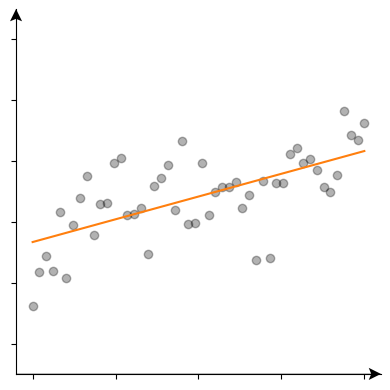

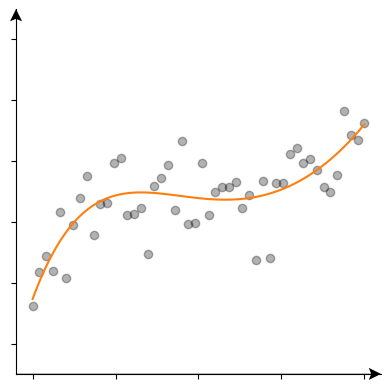

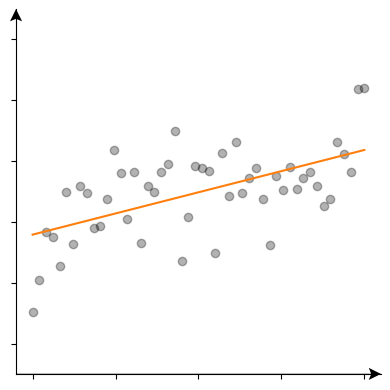

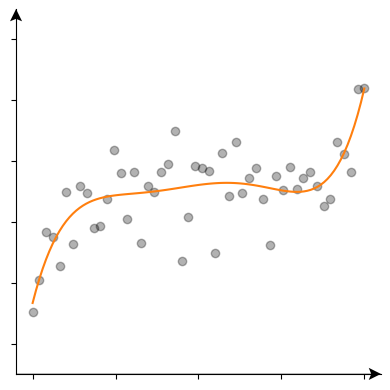

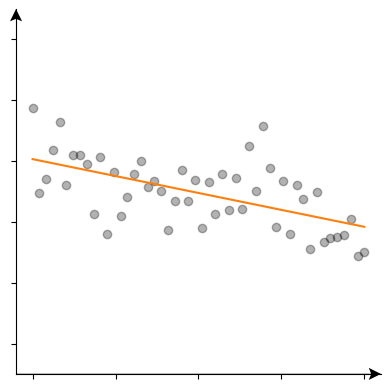

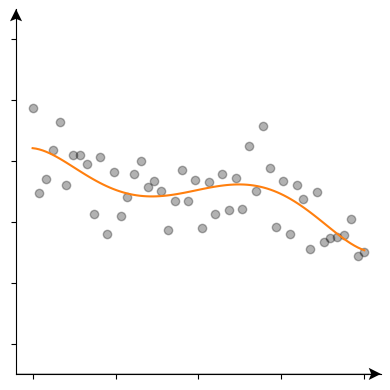

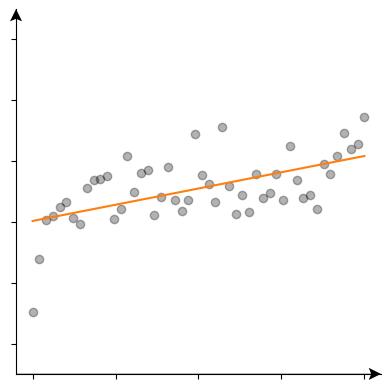

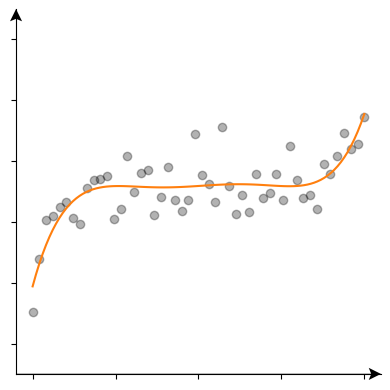

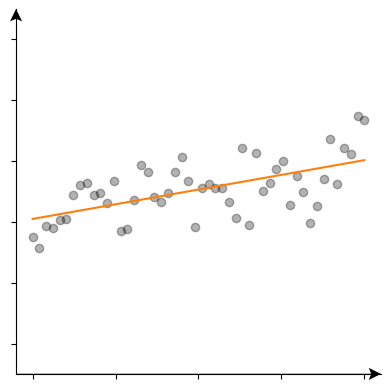

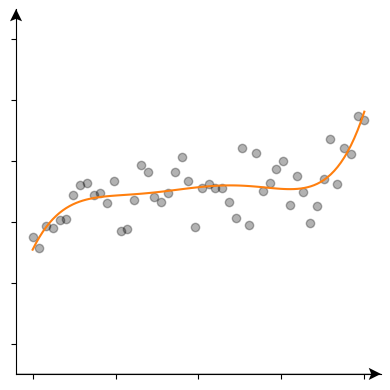

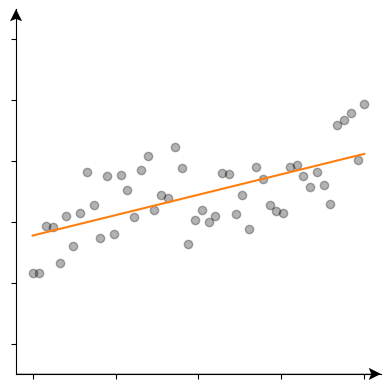

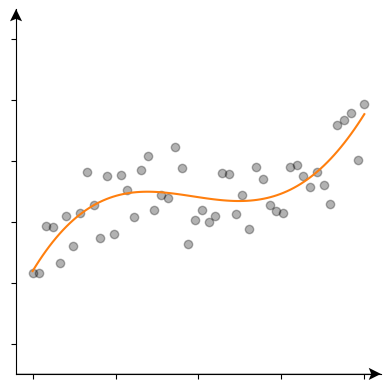

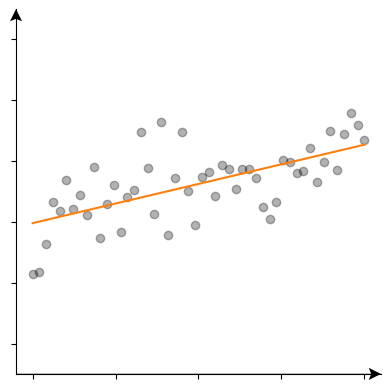

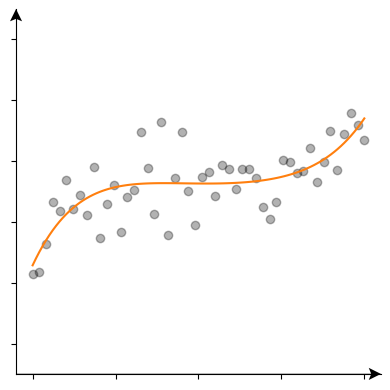

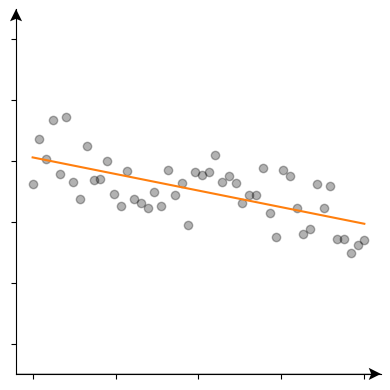

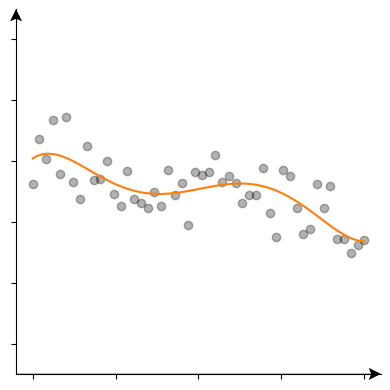

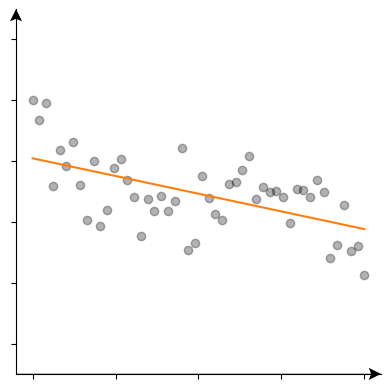

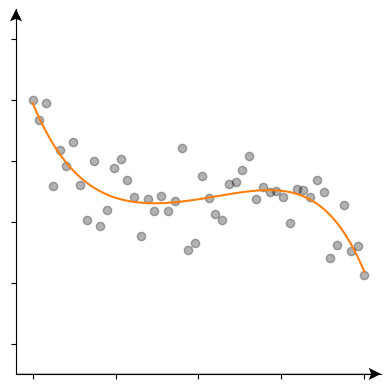

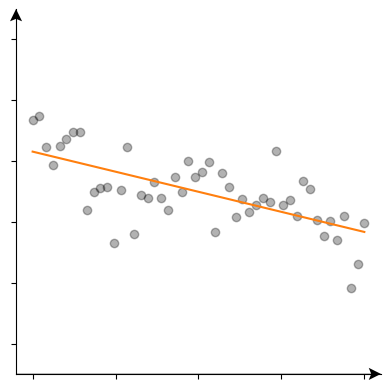

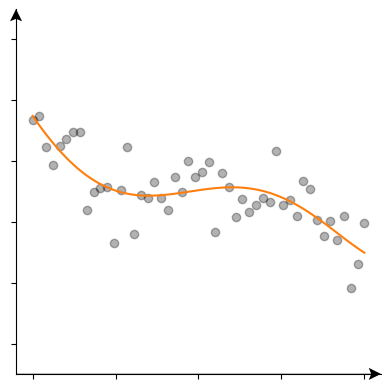

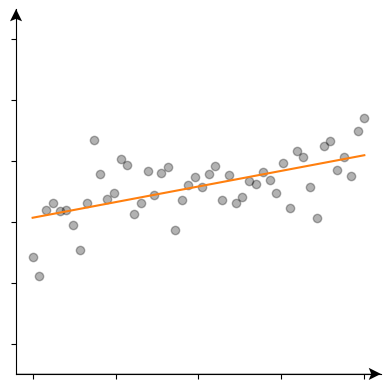

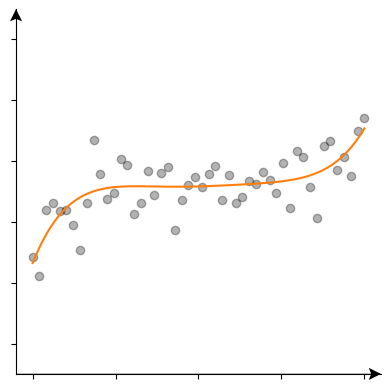

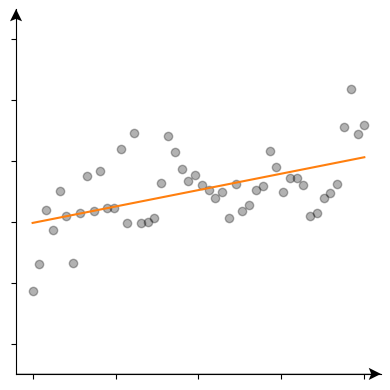

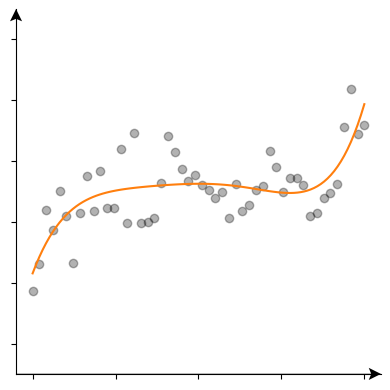

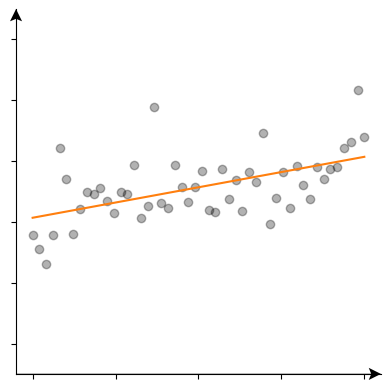

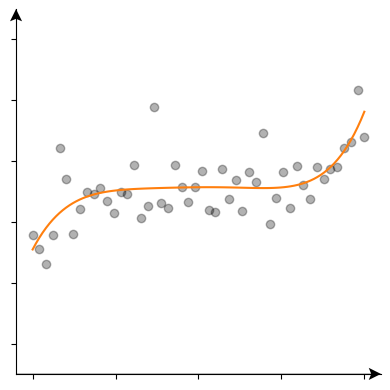

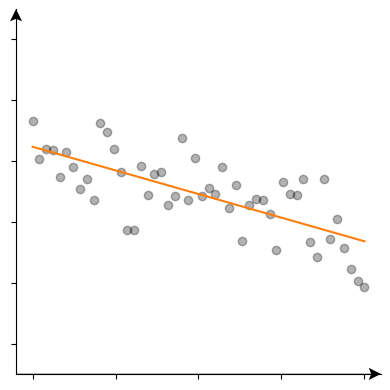

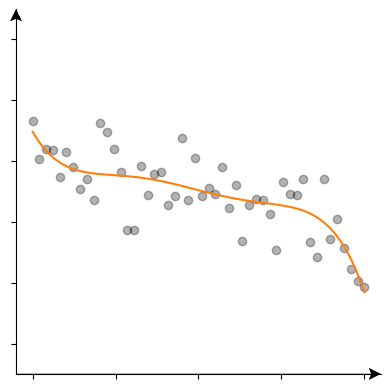

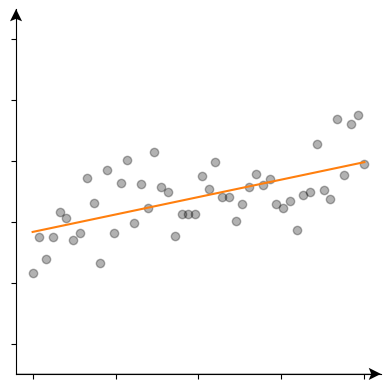

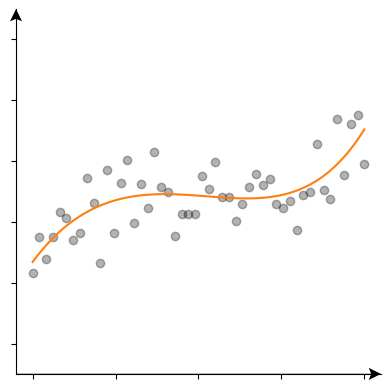

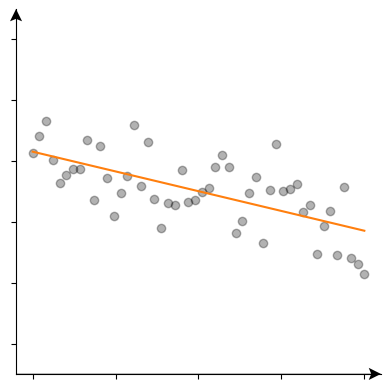

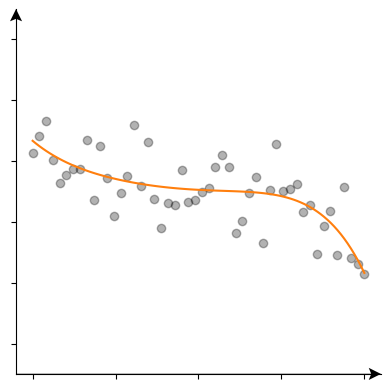

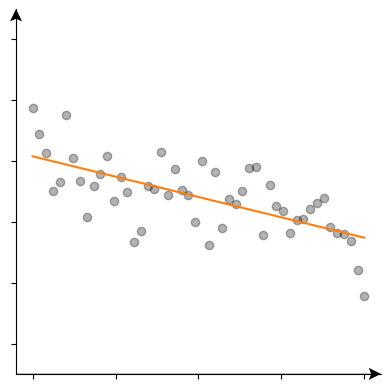

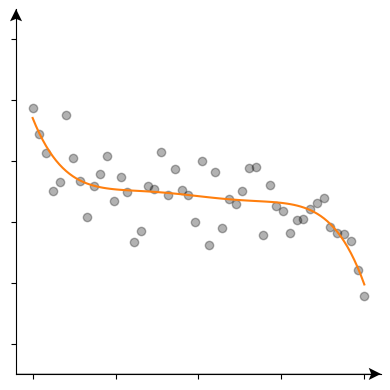

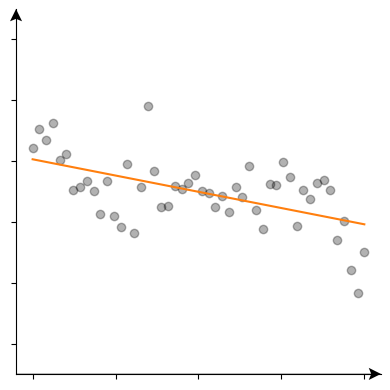

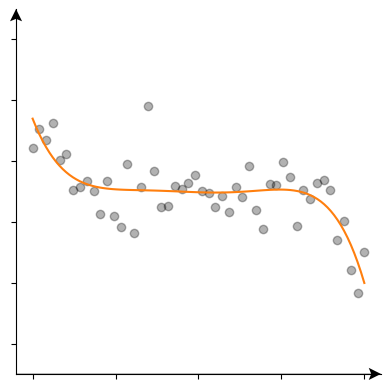

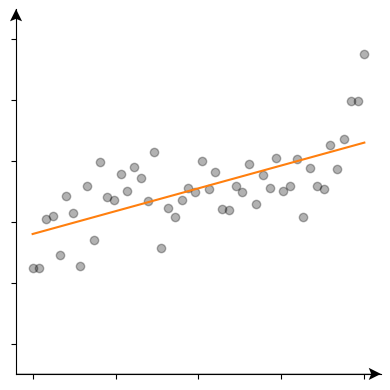

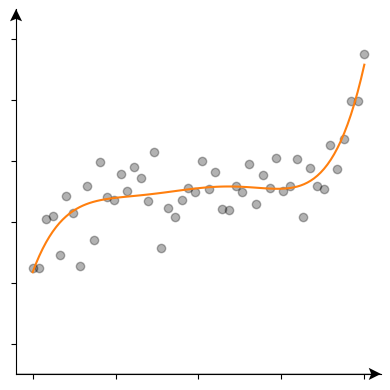

In [7]:
# How the stimuli would look like


# Reproducibility
np.random.seed(0)

# Settings
sample_sizes = [10, 50]
trials_per_condition = 24
training_range = [-1000, 1000]
noise_sd = {"linear": 0.08, "five_poly": 0.08} # Scale is the min and max of training datapoints
# test_range = [3000, 3500]
test_range = training_range
test_n = 50
families = ["linear", "five_poly"]

# Parameter generator
def generate_parameters(family):
    if family == "linear":
        return np.random.uniform(-10, 10, size=2)   # a, b
    elif family == "five_poly":
        return np.random.uniform(-10, 10, size=6)   # a, b, c, d, e, f

# Data‐generation
def generate_data(x, params, family):
    if (family == "linear"):
        return params[1] * x + params[0]
    elif (family=="five_poly"):
        # a x^5 + b x^4 + c x^3 + d x^2 + e x + f
        return (params[5]*x**5 + params[4]*x**4 + params[3]*x**3 +
                params[2]*x**2 + params[1]*x + params[0])

# Collect results
results = []
x_grid = np.linspace(min(np.min(training_range),np.min(test_range)), max(np.max(training_range),np.max(test_range)), 100)
trial_count = 0
for training_n in sample_sizes:
    
    if(training_n<=20):
        train_data_alpha = 0.3
    else:
        train_data_alpha = 0.3
    
    for family in families:
        print(training_n, family)
        for trial_idx in range(1, trials_per_condition + 1):
            params = generate_parameters(family)
            # pad params to length 6 for uniform storage
            params_padded = np.pad(params, (0, 6 - len(params)), constant_values=np.nan)


            # Ground truth
            y_train_true_grid = generate_data(x_grid, params, family)
            
            # Training data (regular grid)
            x_train = np.linspace(training_range[0], training_range[1], training_n)
            #x_train = np.random.uniform(training_range[0], training_range[1], training_n)
            y_train_true = generate_data(x_train, params, family)
            
            # Test data (random)
            x_test = np.sort(np.random.uniform(test_range[0], test_range[1], size=test_n))
            y_test_true = generate_data(x_test, params, family)
            
            # Normalize the signal for noise addition.
            ymin, ymax = compute_norm_yminmax(y_train_true, a=0.25, b=0.75)
            y_train_true = (y_train_true - ymin)/(ymax-ymin)
            y_test_true = (y_test_true - ymin)/(ymax-ymin)
            y_train_true_grid = (y_train_true_grid - ymin)/(ymax-ymin)
            #print(y_train_true.min(), y_train_true.max())
            
            # Add noise
            y_train = y_train_true + np.random.normal(scale=noise_sd[family], size=training_n)
            y_test = y_test_true + np.random.normal(scale=noise_sd[family], size=test_n)
            
            # Fit linear model
            lin_model = make_pipeline(
                MinMaxScaler(feature_range=(-1, 1)),
                LinearRegression()
            ).fit(x_train.reshape(-1,1), y_train)

            # Fit 5th‐degree polynomial
            poly_model = make_pipeline(
                MinMaxScaler(feature_range=(-1, 1)),
                PolynomialFeatures(degree=5, include_bias=False),
                LinearRegression()
            ).fit(x_train.reshape(-1,1), y_train)
            
            # Train loss
            train_pred_lin = lin_model.predict(x_train.reshape(-1,1))
            train_pred_poly = poly_model.predict(x_train.reshape(-1,1))
            train_MAE_lin  = np.mean(np.abs(train_pred_lin  - y_train))
            train_MAE_poly = np.mean(np.abs(train_pred_poly - y_train))
            train_MAE_best = "linear" if train_MAE_lin < train_MAE_poly else "five_poly"
            train_MSE_lin  = np.mean((train_pred_lin  - y_train)**2)
            train_MSE_poly = np.mean((train_pred_poly - y_train)**2)
            train_MSE_best = "linear" if train_MSE_lin < train_MSE_poly else "five_poly"


            MAE_lin = expected_test_loss(params, family, lin_model, [ymin, ymax], sigma=noise_sd[family], loss_type="MAE")
            MSE_lin = expected_test_loss(params, family, lin_model, [ymin, ymax], sigma=noise_sd[family], loss_type="MSE")
            TSE_lin = expected_test_loss(params, family, lin_model, [ymin, ymax], sigma=noise_sd[family], loss_type="TSE")
            MAE_poly = expected_test_loss(params, family, poly_model, [ymin, ymax], sigma=noise_sd[family], loss_type="MAE")
            MSE_poly = expected_test_loss(params, family, poly_model, [ymin, ymax], sigma=noise_sd[family], loss_type="MSE")
            TSE_poly = expected_test_loss(params, family, poly_model, [ymin, ymax], sigma=noise_sd[family], loss_type="TSE")
            MAE_best = "linear" if MAE_lin < MAE_poly else "five_poly"
            MSE_best = "linear" if MSE_lin < MSE_poly else "five_poly"
            TSE_best = "linear" if TSE_lin < TSE_poly else "five_poly"
            
            # Store results
            results.append({
                "ground_truth": family,
                "trial": trial_idx,
                "sample_size": training_n,
                "param1": params_padded[0],
                "param2": params_padded[1],
                "param3": params_padded[2],
                "param4": params_padded[3],
                "param5": params_padded[4],
                "param6": params_padded[5],
                "linear_MAE_train": train_MAE_lin,
                "five_poly_MAE_train": train_MAE_poly,
                "best_model_MAE_train": train_MAE_best,
                "linear_MSE_train": train_MSE_lin,
                "five_poly_MSE_train": train_MSE_poly,
                "best_model_MSE_train": train_MSE_best,
                "linear_MAE": MAE_lin,
                "five_poly_MAE": MAE_poly,
                "best_model_MAE": MAE_best,
                "linear_MSE": MSE_lin,
                "five_poly_MSE": MSE_poly,
                "best_model_MSE": MSE_best,
                "linear_TSE": TSE_lin,
                "five_poly_TSE": TSE_poly,
                "best_model_TSE": TSE_best,
                "ymin": ymin,
                "ymax": ymax,
                "ymin_disp":-0.1,
                "ymax_disp":1.1,
                "x_train": x_train,
                "y_train": y_train,
                "x_test": x_test,
                "y_test": y_test
            })
            
            
            # Plot
            fitted_models = [lin_model, poly_model]
            for fitted_model_idx in range(2):
                fitted_model = fitted_models[fitted_model_idx]
                
                x_curve = np.linspace(training_range[0], test_range[1], 100)
                y_curve  = fitted_model.predict(x_curve.reshape(-1,1))

                for model_color_idx in range(1,2): # Only orange
                    fig,ax = plt.subplots(1,1,figsize=(4,4))
                    ax.scatter(x_train, y_train, color="k", alpha=train_data_alpha, label="Train data")
                    ax.plot(x_curve, y_curve, color="C"+str(model_color_idx), label="Model "+str(model_color_idx+1))
                    ymin = y_train.min() - 1*np.abs(y_train.min())
                    ymax = y_train.max() + 1*np.abs(y_train.min())
                    ax.set_xlim(training_range[0]-100, training_range[1]+100) 
                    ax.set_ylim(-0.1,1.1) 
                    ax.set_xticklabels([])
                    ax.set_yticklabels([])

                    #ax.legend()
                    #ax.set_title("Trial {0}: N_train={1}, true model: {2}".format(trial_count, training_n, family))
                    arrowed_spines(fig, ax, ax.get_xlim(), ax.get_ylim())
                    fig.tight_layout()
                    # Image name: [trial number, N_train index, true model family index, fitted model family index, visualization color index]
                    plt.savefig(os.path.join(stimulus_path, "trial{0}_{1}{2}_{3}{4}".format(trial_count, int(training_n==sample_sizes[1]), int(family==families[1]), fitted_model_idx, model_color_idx)), dpi=200)
                    plt.show()
            trial_count = trial_count+1
# Convert to DataFrame if you want to inspect or save:
df_results = pd.DataFrame(results)
df_results.to_csv(os.path.join(stimulus_path, "stimuli.csv"), index=True)
print(df_results.head())


## Instruction example trials

10 linear


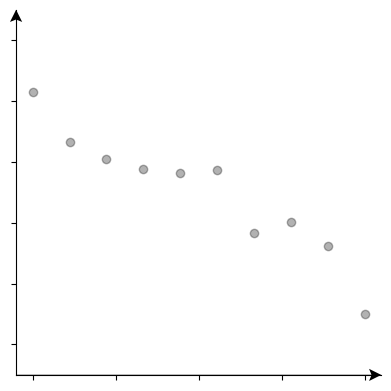

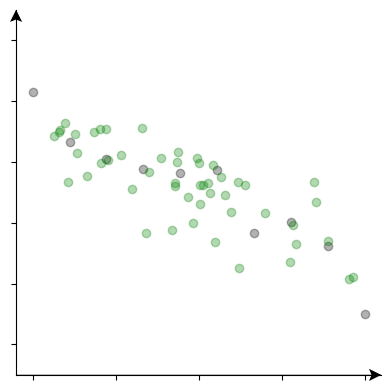

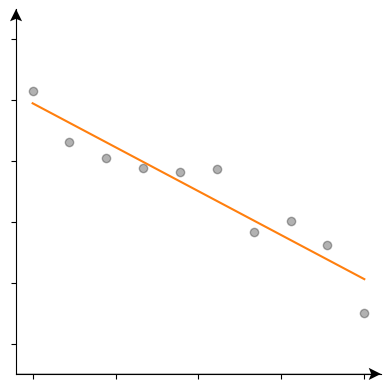

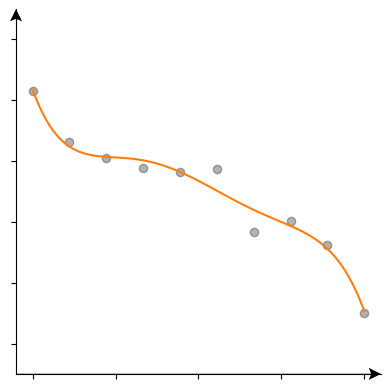

10 five_poly


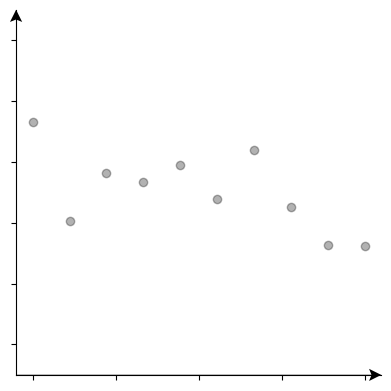

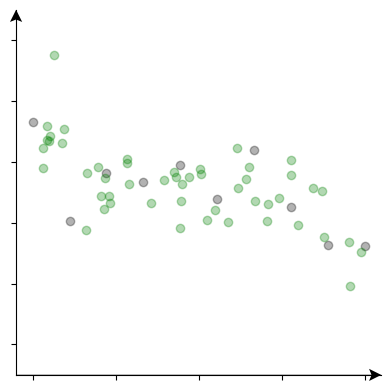

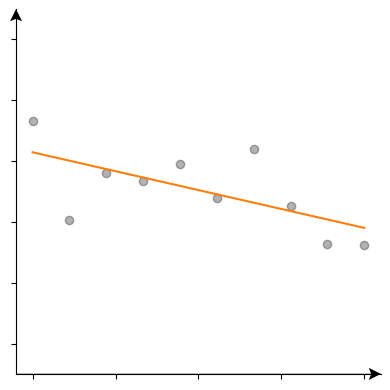

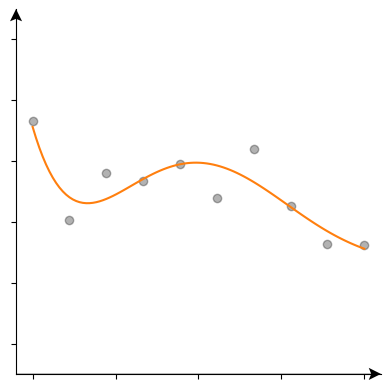

50 linear


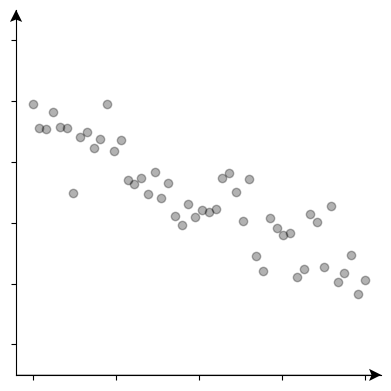

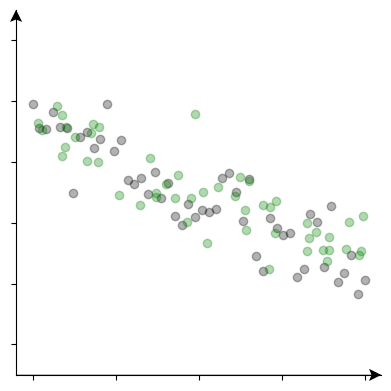

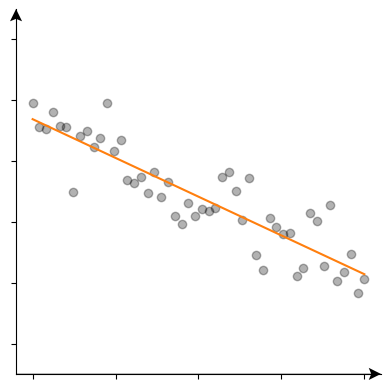

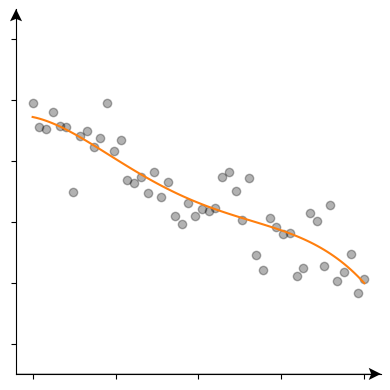

50 five_poly


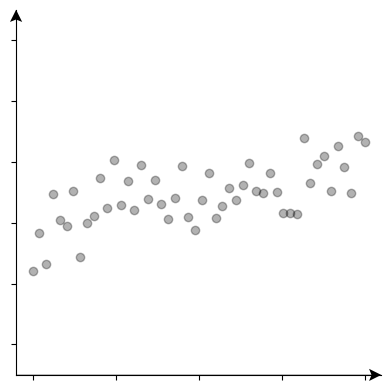

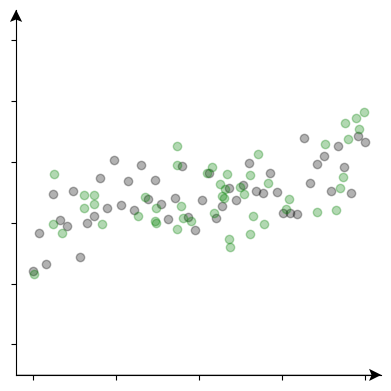

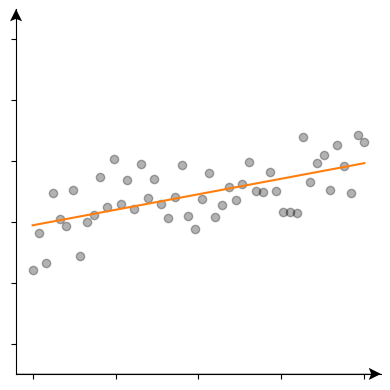

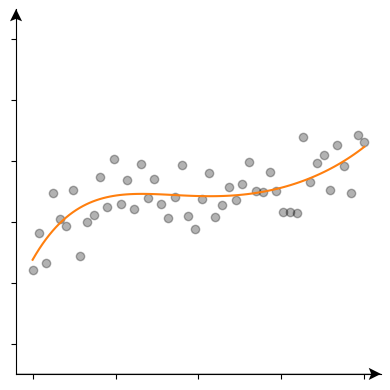

30 linear


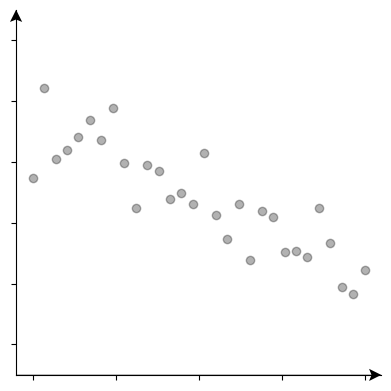

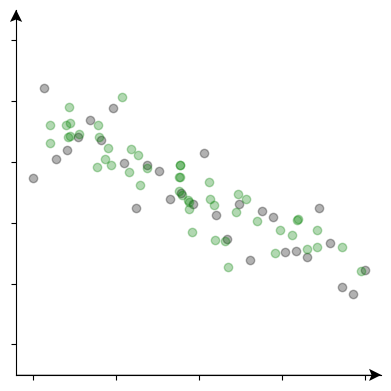

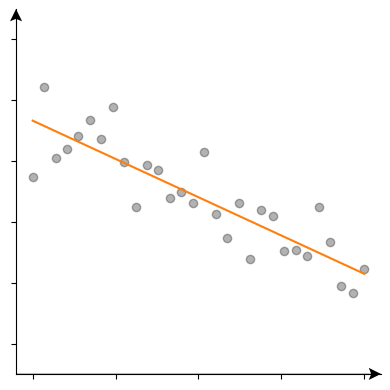

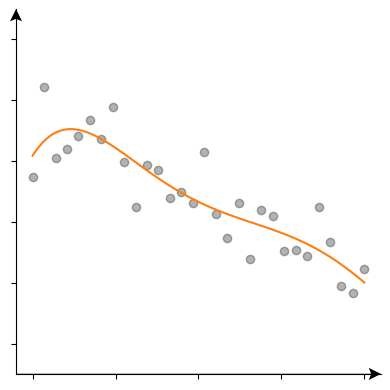

30 five_poly


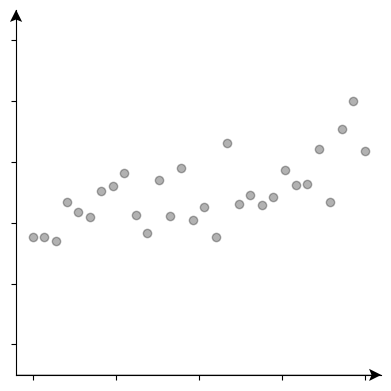

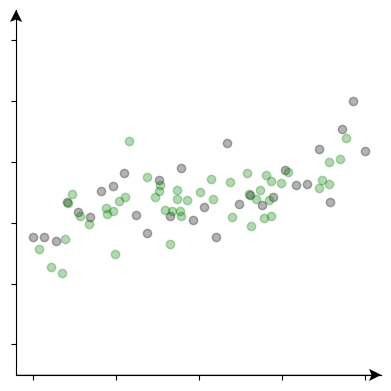

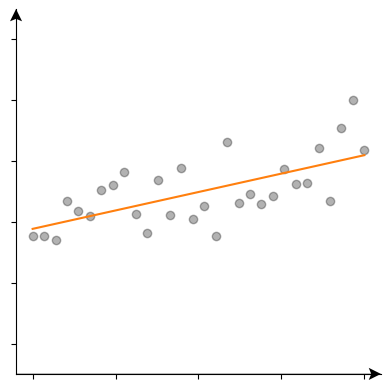

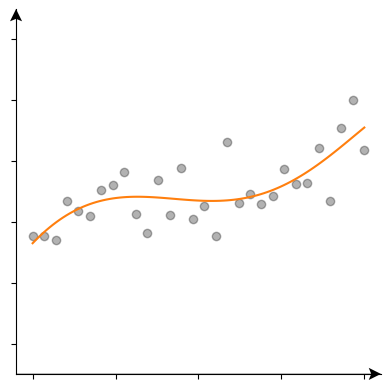

In [11]:
# How the stimuli would look like

# Length of arrowhead
arrow_length = 0.1

# Reproducibility
np.random.seed(2)

# Settings
sample_sizes = [10,50,30] # N_train = 30 for shared instructions
trials_per_condition = 1
training_range = [-1000, 1000]
noise_sd = {"linear": 0.08, "five_poly": 0.08} # Scale is the min and max of training datapoints
# test_range = [3000, 3500]
test_range = training_range
test_n = 50
families = ["linear", "five_poly"]

# Parameter generator
def generate_parameters(family):
    if family == "linear":
        return np.random.uniform(-10, 10, size=2)   # a, b
    elif family == "five_poly":
        return np.random.uniform(-10, 10, size=6)   # a, b, c, d, e, f

# Data‐generation
def generate_data(x, params, family):
    if (family == "linear"):
        return params[1] * x + params[0]
    elif (family=="five_poly"):
        # a x^5 + b x^4 + c x^3 + d x^2 + e x + f
        return (params[5]*x**5 + params[4]*x**4 + params[3]*x**3 +
                params[2]*x**2 + params[1]*x + params[0])

# Collect results
results = []
x_grid = np.linspace(min(np.min(training_range),np.min(test_range)), max(np.max(training_range),np.max(test_range)), 100)
trial_count = 0
for training_n_idx in range(len(sample_sizes)):
    training_n = sample_sizes[training_n_idx]
    
    if(training_n<=20):
        train_data_alpha = 0.3
    else:
        train_data_alpha = 0.3
    
    for family in families:
        print(training_n, family)
        for trial_idx in range(1, trials_per_condition + 1):
            params = generate_parameters(family)
            # pad params to length 6 for uniform storage
            params_padded = np.pad(params, (0, 6 - len(params)), constant_values=np.nan)


            # Ground truth
            y_train_true_grid = generate_data(x_grid, params, family)
            
            # Training data (regular grid)
            x_train = np.linspace(training_range[0], training_range[1], training_n)
            #x_train = np.random.uniform(training_range[0], training_range[1], training_n)
            y_train_true = generate_data(x_train, params, family)
            
            # Test data (random)
            x_test = np.sort(np.random.uniform(test_range[0], test_range[1], size=test_n))
            y_test_true = generate_data(x_test, params, family)
            
            # Normalize the signal for noise addition.
#             ymin = min(y_train_true.min(), y_test_true.min()) - 1*np.abs(min(y_train_true.min(), y_test_true.min()))
#             ymax = max(y_train_true.max(), y_test_true.max()) + 1*np.abs(max(y_train_true.max(), y_test_true.max()))
            ymin, ymax = compute_norm_yminmax(y_train_true, a=0.25, b=0.75)
            y_train_true = (y_train_true - ymin)/(ymax-ymin)
            y_test_true = (y_test_true - ymin)/(ymax-ymin)
            y_train_true_grid = (y_train_true_grid - ymin)/(ymax-ymin)
            
            # Add noise
            y_train = y_train_true + np.random.normal(scale=noise_sd[family], size=training_n)
            y_test = y_test_true + np.random.normal(scale=noise_sd[family], size=test_n)
            
            # Fit linear model
            lin_model = LinearRegression().fit(x_train.reshape(-1,1), y_train)
            
            # Fit 5th‐degree polynomial
            poly_model = make_pipeline(
                PolynomialFeatures(degree=5, include_bias=False), # include_bias=False, because the intercept will be added by LinearRegression()
                LinearRegression()
            ).fit(x_train.reshape(-1,1), y_train)
            
            # Predictions
            pred_lin = lin_model.predict(x_test.reshape(-1,1))
            pred_poly = poly_model.predict(x_test.reshape(-1,1))
            
            # Compute errors
#             err_lin  = np.sum(np.abs(pred_lin  - y_test))
#             err_poly = np.sum(np.abs(pred_poly - y_test))
            err_lin  = np.sum((pred_lin  - y_test)**2)
            err_poly = np.sum((pred_poly - y_test)**2)
            best = "linear" if err_lin < err_poly else "five_poly"
            
            # Store results
            results.append({
                "ground_truth": family,
                "trial": trial_idx,
                "sample_size": training_n,
                "param1": params_padded[0],
                "param2": params_padded[1],
                "param3": params_padded[2],
                "param4": params_padded[3],
                "param5": params_padded[4],
                "param6": params_padded[5],
                "linear_error": err_lin,
                "five_poly_error": err_poly,
                "best_model": best
            })
            
            # Plot
            fig,ax = plt.subplots(1,1,figsize=(4,4))
            ax.scatter(x_train, y_train, color="k", alpha=train_data_alpha, label="Train data")
            ax.set_xlim(training_range[0]-100, training_range[1]+100) 
            ax.set_ylim(-0.1,1.1) 
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            fig.tight_layout()
            arrowed_spines(fig, ax, ax.get_xlim(), ax.get_ylim())
            plt.savefig(os.path.join(stimulus_path, "instructions_trial{0}_{1}{2}_train".format(trial_count, int(training_n_idx), int(family==families[1]))), dpi=200)
            plt.show()
            
            fig,ax = plt.subplots(1,1,figsize=(4,4))
            ax.scatter(x_train, y_train, color="k", alpha=train_data_alpha, label="Train data")
            ax.scatter(x_test, y_test, color="g", alpha=train_data_alpha, label="Test data")
            ax.set_xlim(training_range[0]-100, training_range[1]+100) 
            ax.set_ylim(-0.1,1.1) 
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            fig.tight_layout()
            arrowed_spines(fig, ax, ax.get_xlim(), ax.get_ylim())
            plt.savefig(os.path.join(stimulus_path, "instructions_trial{0}_{1}{2}_traintest".format(trial_count, int(training_n_idx), int(family==families[1]))), dpi=200)
            plt.show()
                
            fitted_models = [lin_model, poly_model]
            for fitted_model_idx in range(2):
                fitted_model = fitted_models[fitted_model_idx]
                
                x_curve = np.linspace(training_range[0], test_range[1], 100)
                y_curve  = fitted_model.predict(x_curve.reshape(-1,1))
                
                for model_color_idx in range(1,2): # Only orange
                    fig,ax = plt.subplots(1,1,figsize=(4,4))
                    ax.scatter(x_train, y_train, color="k", alpha=train_data_alpha, label="Train data")
                    ax.plot(x_curve, y_curve, color="C"+str(model_color_idx), label="Model "+str(model_color_idx+1))
                    ax.set_xlim(training_range[0]-100, training_range[1]+100) 
                    ax.set_ylim(-0.1,1.1) 
                    ax.set_xticklabels([])
                    ax.set_yticklabels([])

                    #ax.legend()
                    #ax.set_title("Trial {0}: N_train={1}, true model: {2}".format(trial_count, training_n, family))
                    arrowed_spines(fig, ax, ax.get_xlim(), ax.get_ylim())
                    fig.tight_layout()
                    # Image name: [trial number, N_train index, true model family index, fitted model family index, visualization color index]
                    plt.savefig(os.path.join(stimulus_path, "instructions_trial{0}_{1}{2}_{3}{4}".format(trial_count, int(training_n_idx), int(family==families[1]), fitted_model_idx, model_color_idx)), dpi=200)
                    plt.show()
            trial_count = trial_count+1
# Convert to DataFrame if you want to inspect or save:
# df_results = pd.DataFrame(results)
# df_results.to_csv(os.path.join(stimulus_path, "stimuli_instructions.csv"), index=True)
# print(df_results.head())


## Clarification of the data generation process and noise

1000 linear


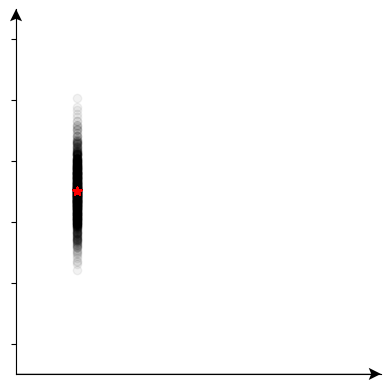

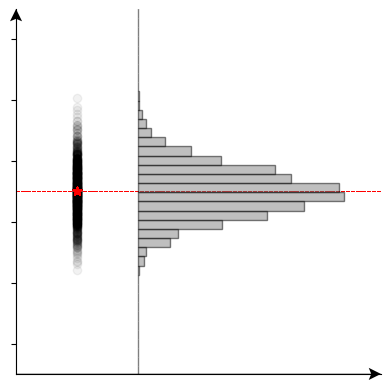

1000 linear


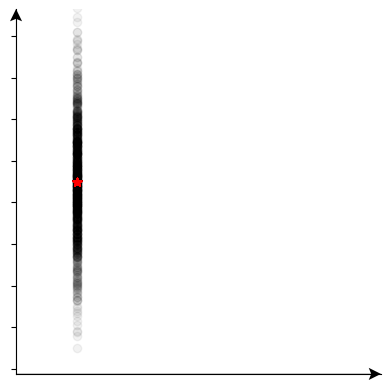

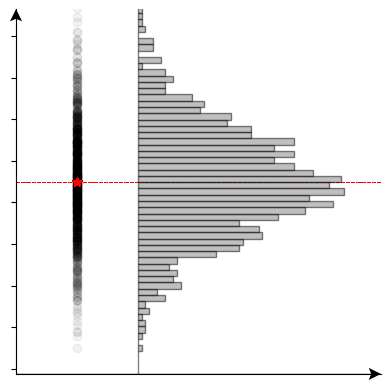

In [8]:
# How the stimuli would look like

# Length of arrowhead
arrow_length = 0.1


# Settings
sample_sizes = [1000] # N_train = 30 for shared instructions
trials_per_condition = 1
training_range = [-1000,1000]
hist_bins = {0.25: 200, 0.08: 200}
# test_range = [3000, 3500]
test_range = training_range
test_n = 50
families = ["linear"]

# Parameter generator
def generate_parameters(family):
    if family == "linear":
        return np.random.uniform(-10, 10, size=2)   # a, b
    elif family == "five_poly":
        return np.random.uniform(-10, 10, size=6)   # a, b, c, d, e, f

# Data‐generation
def generate_data(x, params, family):
    if (family == "linear"):
        return params[1] * x + params[0]
    elif (family=="five_poly"):
        # a x^5 + b x^4 + c x^3 + d x^2 + e x + f
        return (params[5]*x**5 + params[4]*x**4 + params[3]*x**3 +
                params[2]*x**2 + params[1]*x + params[0])

# Collect results
results = []
x_grid = np.linspace(min(np.min(training_range),np.min(test_range)), max(np.max(training_range),np.max(test_range)), 100)
trial_count = 0

for noise_sd_val in [0.08,0.25]:
    # Reproducibility
    np.random.seed(100)
    
    if(noise_sd_val<0.1):
        noise_sd_cond = "small"
    else:
        noise_sd_cond = "large"
    noise_sd = {"linear": noise_sd_val} # Scale is the min and max of training datapoints
    for training_n_idx in range(len(sample_sizes)):
        training_n = sample_sizes[training_n_idx]

        if(training_n<=20):
            train_data_alpha = 0.05
        else:
            train_data_alpha = 0.05

        for family in families:
            print(training_n, family)
            for trial_idx in range(1, trials_per_condition + 1):
                params = generate_parameters(family)
                # pad params to length 6 for uniform storage
                params_padded = np.pad(params, (0, 6 - len(params)), constant_values=np.nan)


                # Ground truth
                y_train_true_grid = generate_data(x_grid, params, family)

                # Training data (regular grid)
                x_train = np.linspace(training_range[0], training_range[1], 30)
                x_train_display = -0.5*np.ones((training_n)) # This is an instruction figure to illustrate noise
                #x_train = np.random.uniform(training_range[0], training_range[1], training_n)
                y_train_true = generate_data(x_train, params, family)
                y_train_display_true = generate_data(x_train_display, params, family)

                # Test data (random)
                x_test = np.sort(np.random.uniform(test_range[0], test_range[1], size=test_n))
                y_test_true = generate_data(x_test, params, family)

                # Normalize the signal for noise addition.
#                 ymin = min(y_train_true.min(), y_test_true.min()) - 1*np.abs(min(y_train_true.min(), y_test_true.min()))
#                 ymax = max(y_train_true.max(), y_test_true.max()) + 1*np.abs(max(y_train_true.max(), y_test_true.max()))
                ymin, ymax = compute_norm_yminmax(y_train_true, a=0.25, b=0.75)
                y_train_true = (y_train_true - ymin)/(ymax-ymin)
                y_train_display_true = (y_train_display_true - ymin)/(ymax-ymin)
                y_test_true = (y_test_true - ymin)/(ymax-ymin)
                y_train_true_grid = (y_train_true_grid - ymin)/(ymax-ymin)

                # Add noise
                y_train = y_train_true + np.random.normal(scale=noise_sd[family], size=30)
                y_train_display = y_train_display_true + np.random.normal(scale=noise_sd[family], size=training_n)
                y_test = y_test_true + np.random.normal(scale=noise_sd[family], size=test_n)

                # Fit linear model
                lin_model = LinearRegression().fit(x_train.reshape(-1,1), y_train)

                # Fit 5th‐degree polynomial
                poly_model = make_pipeline(
                    PolynomialFeatures(degree=5, include_bias=False), # include_bias=False, because the intercept will be added by LinearRegression()
                    LinearRegression()
                ).fit(x_train.reshape(-1,1), y_train)

                # Predictions
                pred_lin = lin_model.predict(x_test.reshape(-1,1))
                pred_poly = poly_model.predict(x_test.reshape(-1,1))

                # Compute errors
                err_lin  = np.sum((pred_lin  - y_test)**2)
                err_poly = np.sum((pred_poly - y_test)**2)
                best = "linear" if err_lin < err_poly else "five_poly"

                # Store results
                results.append({
                    "ground_truth": family,
                    "trial": trial_idx,
                    "sample_size": training_n,
                    "param1": params_padded[0],
                    "param2": params_padded[1],
                    "param3": params_padded[2],
                    "param4": params_padded[3],
                    "param5": params_padded[4],
                    "param6": params_padded[5],
                    "linear_error": err_lin,
                    "five_poly_error": err_poly,
                    "best_model": best
                })

                # Plot
                if(noise_sd_cond=="small"):
                    ymin=-0.1
                    ymax=1.1
                else:
                    ymin = y_train.min() - 2*np.abs(y_train.min())
                    ymax = y_train.max() + 2*np.abs(y_train.min())
                fig,ax = plt.subplots(1,1,figsize=(4,4))
                ax.scatter(x_train_display, y_train_display, color="k", alpha=train_data_alpha, label="Train data")
                ax.scatter(x_train_display, y_train_display_true, marker="*", color="r", alpha=1, label="Train data true signal")
                ax.set_xlim(-1,2) 
                ax.set_ylim(ymin,ymax) 
                ax.set_xticklabels([])
                ax.set_xticks([])
                ax.set_yticklabels([])
                arrowed_spines(fig, ax, ax.get_xlim(), ax.get_ylim())
                fig.tight_layout()
                plt.savefig(os.path.join(stimulus_path, "instructions_trial_noise"+str(noise_sd_cond)), dpi=200)
                plt.show()

                # Plot with histogram
                fig,ax = plt.subplots(1,1,figsize=(4,4))
                ax.scatter(x_train_display, y_train_display, color="k", alpha=train_data_alpha, label="Train data")
                ax.scatter(x_train_display, y_train_display_true, marker="*", color="r", alpha=1, label="Train data true signal")
                ax.plot([-1,2],[y_train_display_true,y_train_display_true],"r--", linewidth=0.7, alpha=0.01)
                ax.set_xlim(-1,2) 
                ax.set_ylim(ymin,ymax) 
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                arrowed_spines(fig, ax, ax.get_xlim(), ax.get_ylim())

                # Add vertical histogram to the right
                ax_hist = ax.twinx()  # share y-axis
                # Compute histogram counts
                counts, bin_edges = np.histogram(y_train_display, bins=np.linspace(-3,3,hist_bins[noise_sd[family]]))
                # Normalize so tallest bar = 2
                scale = 1.7 / counts.max()
                counts = counts * scale
                # Plot histogram manually using barh (horizontal bars)
                ax_hist.barh(
                    (bin_edges[:-1] + bin_edges[1:]) / 2,  # bin centers
                    counts,                                # scaled widths
                    height=np.diff(bin_edges),             # bin heights
                    color="gray", alpha=0.5, edgecolor="k"
                )
                # Move the histogram to the right side visually
                ax_hist.set_ylim(ax.get_ylim())
                ax_hist.set_xticks([])  # hide duplicate y-ticks
                ax_hist.set_yticks([])  # hide duplicate y-ticks
                ax_hist.set_xticklabels([])
                ax_hist.set_yticklabels([])
                ax_hist.set_frame_on(False)   # removes all spines for the twin axis
                fig.tight_layout()
                plt.savefig(os.path.join(stimulus_path, "instructions_trial_noise"+str(noise_sd_cond)+"_histogram"), dpi=200)
                plt.show()

                trial_count = trial_count+1
